In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from joblib import Parallel,delayed
from multiprocessing import cpu_count
import pandas as pd
from tqdm.notebook import tqdm
import os
import cmath
import time
import math
import bilby
import tempfile
import h5py
from tkinter import Tcl

from scipy.interpolate import interp1d,RectBivariateSpline
from scipy.integrate import solve_ivp
from scipy.special import factorial2,beta
from scipy.integrate import quad,nquad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,toms748,minimize
import scipy.stats as st
import seaborn as sns

# Statistical Functions

In [4]:
class gaussian:
    def __init__(self,mean,cov):
        self.mean=mean
        self.cov=cov
        
    def UV(self,x):
        sig= (self.cov)**(1/2)
        mu= self.mean
        p= 1./(sig*np.sqrt(2.*np.pi))*np.exp(-np.power((x - mu)/sig, 2.)/2)
        return p
    
    def MV(self,x):
        x=np.array(x)
        mu=np.array(self.mean)
        cov=np.array(self.cov)
        part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
        part2 = (-1/2) * ((x-mu).dot(np.linalg.inv(cov))).dot((x-mu).T)
        return part1 * np.exp(part2)
    
    def __call__(self,x):
        if type(self.mean)==list:
            return self.MV(x)
        else:
            return self.UV(x)
    
def CI2sig(dx,CI):
    alpha= 1-CI
    z_score= st.norm.ppf(1-alpha/2)
    sig= dx/z_score
    return sig

def uniform(x,a,b):
    if min([a,b])<=x<=max([a,b]):
        return 1/abs(b-a)
    else:
        return 0

def CI_calc(x,px,f,typ="mean"):
    if typ=="mean":
        mean= quad(interp1d(x,x*px),x[0],x[-1])[0]
    elif typ=="median":
        mean= x[np.argmax(px)]
    minus= toms748(lambda X: quad(interp1d(x,px),x[0],X)[0]-(1-f)/2,x[0],mean)
    plus= toms748(lambda X: quad(interp1d(x,px),x[0],X)[0]-(1+f)/2,mean,x[-1])
    return [mean,plus,minus]
  

def array_from_samp(x,N,perc=10):
    xmin= min(x)
    xmax= max(x)
    mean= (xmax+xmin)/2
    f= perc/100
    xmin= xmin - mean*f
    xmax= xmax + mean*f
    return np.linspace(xmin,xmax,N)

class integrator:
    def __init__(self,func,limits,N):
        n= len(limits)
        vals_range= []
        for i in range(n):
            lim= limits[i]
            vals_range.append(np.linspace(lim[0],lim[1],N))
            
        vals_grid= np.meshgrid(*vals_range)
        vals=[]
        for val in vals_grid:
            vals.append(val.flatten())
            
        vals= np.transpose(vals)
        P= []
        for val in vals:
            P.append(func(*val))
            
        self.P_grid= np.reshape(P,[N]*n)
        self.vals_range= vals_range
        
    def __call__(self):
        return sum(self.P_grid.flatten())
    
def normalize(x,px,method="S"):
    if method=="I":
        x2p= interp1d(x,px)
        norm= quad(x2p,x[0],x[-1])[0]
    else:
        dx= np.gradient(x)
        norm= sum(px*dx)
    return np.array(px)/norm

def metropolis_hastings(target_density,x0,burnin_size=1000,size=50000,pbar=True):
    size += burnin_size
    xt = x0
    n= len(x0)
    samples = []
    for i in tqdm(range(size),disable=not(pbar)):
        xt_candidate = np.random.multivariate_normal(xt, np.eye(n))
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    return samples

class sampling_2d:
    def __init__(self,pdf,x_lim,y_lim,n_grid=100,n_samp=2000):
        x_range= np.linspace(*x_lim,n_grid)
        y_range= np.linspace(*y_lim,n_grid)
        
        P_xy= np.transpose(Parallel(n_jobs=-1,mmap_mode="r+")(delayed(lambda y: [pdf(x,y) for x in x_range])(y) for y in tqdm(y_range))) 
        self.xy2P= RectBivariateSpline(x_range,y_range,P_xy)
        self.x_range=x_range
        self.y_range=y_range
        
        Px= np.sum(P_xy,axis=1)
        c2x= self.cdf2x(x_range,Px)
        c= np.linspace(0,1,n_samp)
        self.x_samples= c2x(c)
        
    def cdf2x(self,x,px):
        px= normalize(x,px)
        cdf= np.cumsum(px)
        c2x= interp1d(cdf/cdf[-1],x,bounds_error=False,fill_value=(x[0],x[-1]))
        return c2x
    
    def generate(self,x_samples=None):
        if x_samples is None:
            x_samples= self.x_samples
        y_range= self.y_range
        
        def sub_func(x):
            py= [self.xy2P(x,y)[0][0] for y in y_range]
            c2y= self.cdf2x(y_range,py)
            c= np.random.uniform(0,1,1)
            y_samp= c2y(c)[0]
            return y_samp
        
        y_samples= Parallel(n_jobs=-1,mmap_mode="r+")(delayed(sub_func)(xi) for xi in tqdm(x_samples))
        
        return x_samples, np.array(y_samples)

In [5]:
def error_str(data_conf):
    
    if type(data_conf[0])==list or type(data_conf[0])==tuple or type(data_conf[0])==np.ndarray:
        str_store= []
        for data in data_conf:
            x,x_plus,x_minus= data
            if x_plus>x_minus:
                delx_plus= x_plus- x
                delx_minus= x - x_minus
            else:
                delx_plus= x_minus- x
                delx_minus= x - x_plus
            str_store.append("$%0.2f^{+%0.2f}_{-%0.2f}$" %(x,delx_plus,delx_minus))
    else:
        x,x_plus,x_minus= data_conf
        if x_plus>x_minus:
            delx_plus= x_plus- x
            delx_minus= x - x_minus
        else:
            delx_plus= x_minus- x
            delx_minus= x - x_plus
        str_store= "$%0.2f^{+%0.2f}_{-%0.2f}$" %(x,delx_plus,delx_minus)

    return str_store

# Data Extraction

In [6]:
class Ensemble_Extraction:
    def __init__(self,path):
        self.Ensemble_Data= self.Extraction(path)
        
        Data= dict()
        Data["M"]= []
        Data["R"]= []
        Data["L"]= []
        Data["f"]= []
        Data["t"]= []
        
        self.Data= Data

    def M_extract(self,Mass,M,Ec,*params):
        Mmax= max(M)
        if Mass>Mmax:
            return None
        
        M2Ec= interp1d(M,Ec)
        Ec_at_M= M2Ec(Mass)
        P_at_M= []
        for P in params:
            P_at_M.append(interp1d(Ec,P)(Ec_at_M))
            
        return P_at_M
    
    def Extraction(self,path):

        Data= dict()
        for file in tqdm(Tcl().call('lsort', '-dict', os.listdir(path))):
            if file.endswith(".json"): dat= readDict(path+file)
            else: continue

            Ec_array= dat["Ec"]
            M_array= dat["M"]
            R_array= dat["R"]
            Lamda_array= dat["Lambda"]
            f_array= dat["NRO_GR"]["f"]
            tao_array= dat["NRO_GR"]["DT"]

            if min(tao_array)<0.1 or min(M_array)<0.7:
                continue

            eos= file[:-5]
            Data[eos]= dict()
            Data[eos]["Ec"]= Ec_array
            Data[eos]["M"]= M_array
            Data[eos]["R"]= R_array
            Data[eos]["L"]= Lamda_array
            Data[eos]["f"]= f_array
            Data[eos]["t"]= tao_array

        return Data
    
    def __call__(self,*Mass):
        Data= self.Data
        
        if len(Mass)>=1:
            for m in Mass:
                if m==max:
                    Data["M_max"]= []
                    Data["R_max"]= []
                    Data["L_max"]= []
                    Data["f_max"]= []
                    Data["t_max"]= []
                    continue
                Data["R_%s" %m]= []
                Data["L_%s" %m]= []
                Data["f_%s" %m]= []
                Data["t_%s" %m]= []
        
        for dat in tqdm(self.Ensemble_Data.values()):
            Ec= dat["Ec"]
            M= dat["M"]
            R= dat["R"]
            L= dat["L"]     
            f= dat["f"] 
            t= dat["t"]
                        
            Data["M"].append(M)
            Data["R"].append(R)
            Data["L"].append(L)
            Data["f"].append(f)
            Data["t"].append(t)
            
            if len(Mass)>=1:
                for m in Mass:
                    if m==max:
                        Data["M_max"].append(M[-1])
                        Data["R_max"].append(R[-1])
                        Data["L_max"].append(L[-1])
                        Data["f_max"].append(f[-1])
                        Data["t_max"].append(t[-1])
                        continue
                    p_at_m= self.M_extract(m,M,Ec,R,L,f,t)
                    if p_at_m==None:
                        continue
                    R_m,L_m,f_m,t_m= p_at_m
                    Data["R_%s" %m].append(R_m)
                    Data["L_%s" %m].append(L_m)
                    Data["f_%s" %m].append(f_m)
                    Data["t_%s" %m].append(t_m)
            
        Data["M"]= np.concatenate(Data["M"])
        Data["R"]= np.concatenate(Data["R"])
        Data["L"]= np.concatenate(Data["L"])
        Data["f"]= np.concatenate(Data["f"])
        Data["t"]= np.concatenate(Data["t"]) 

        if len(Mass)>=1:
            for m in Mass:
                if m==max:
                    Data["M_max"]= np.array(Data["M_max"])
                    Data["R_max"]= np.array(Data["R_max"])
                    Data["L_max"]= np.array(Data["L_max"])
                    Data["f_max"]= np.array(Data["f_max"])
                    Data["t_max"]= np.array(Data["t_max"])
                    continue
                Data["R_%s" %m]= np.array(Data["R_%s" %m])
                Data["L_%s" %m]= np.array(Data["L_%s" %m])
                Data["f_%s" %m]= np.array(Data["f_%s" %m])
                Data["t_%s" %m]= np.array(Data["t_%s" %m])
        
        return Data

In [8]:
Data= readDict("Data.json")
PSR= Data["PSR"]
GW= Data["PSR+GW"]
NICER= Data["PSR+GW+NICER"]

# Envelope Plot

In [9]:
class Envelope:
    def __init__(self,EOS_set,M_array):

        def sub_func(eos):
            M2f= interp1d(eos["M"],eos["f"],bounds_error=False,fill_value=np.nan)
            f_array= M2f(M_array)
            return f_array
        
        f_grid= Parallel(n_jobs=-1)(delayed(sub_func)(eos) for eos in tqdm(EOS_set.values())) 
            
        self.f_grid= np.array(f_grid)
        self.M_array= M_array
        
    def CI(self,f):
        if len(f)<1:
            return [np.nan]*3
        frac= 0.9
        x= (1-frac)/2
        return np.mean(f),np.quantile(f,1-x),np.quantile(f,x)
    
    def __call__(self):
        M_array= self.M_array
        f_mean=[]
        f_pls=[]
        f_minus=[]
        
        def sub_func(i):
            f_samp= self.f_grid[:,i]
            f_samp= f_samp[~np.isnan(f_samp)]
            return self.CI(f_samp)
        
        X= Parallel(-1)(delayed(sub_func)(i) for i in range(len(M_array)))
        
        for x in X:
            mu,pls,minus= x
            f_mean.append(mu)
            f_pls.append(pls)
            f_minus.append(minus)
        return M_array,f_mean,f_pls,f_minus

In [10]:
N= 150

CIs = [Envelope(PSR_class.Ensemble_Data,array_from_samp(PSR["M"],N,0))(),
       Envelope(GW_class.Ensemble_Data,array_from_samp(GW["M"],N,-1))(),
       Envelope(NICER_class.Ensemble_Data,array_from_samp(NICER["M"],N,-3))()]

  0%|          | 0/9835 [00:00<?, ?it/s]

  0%|          | 0/9557 [00:00<?, ?it/s]

  0%|          | 0/9607 [00:00<?, ?it/s]

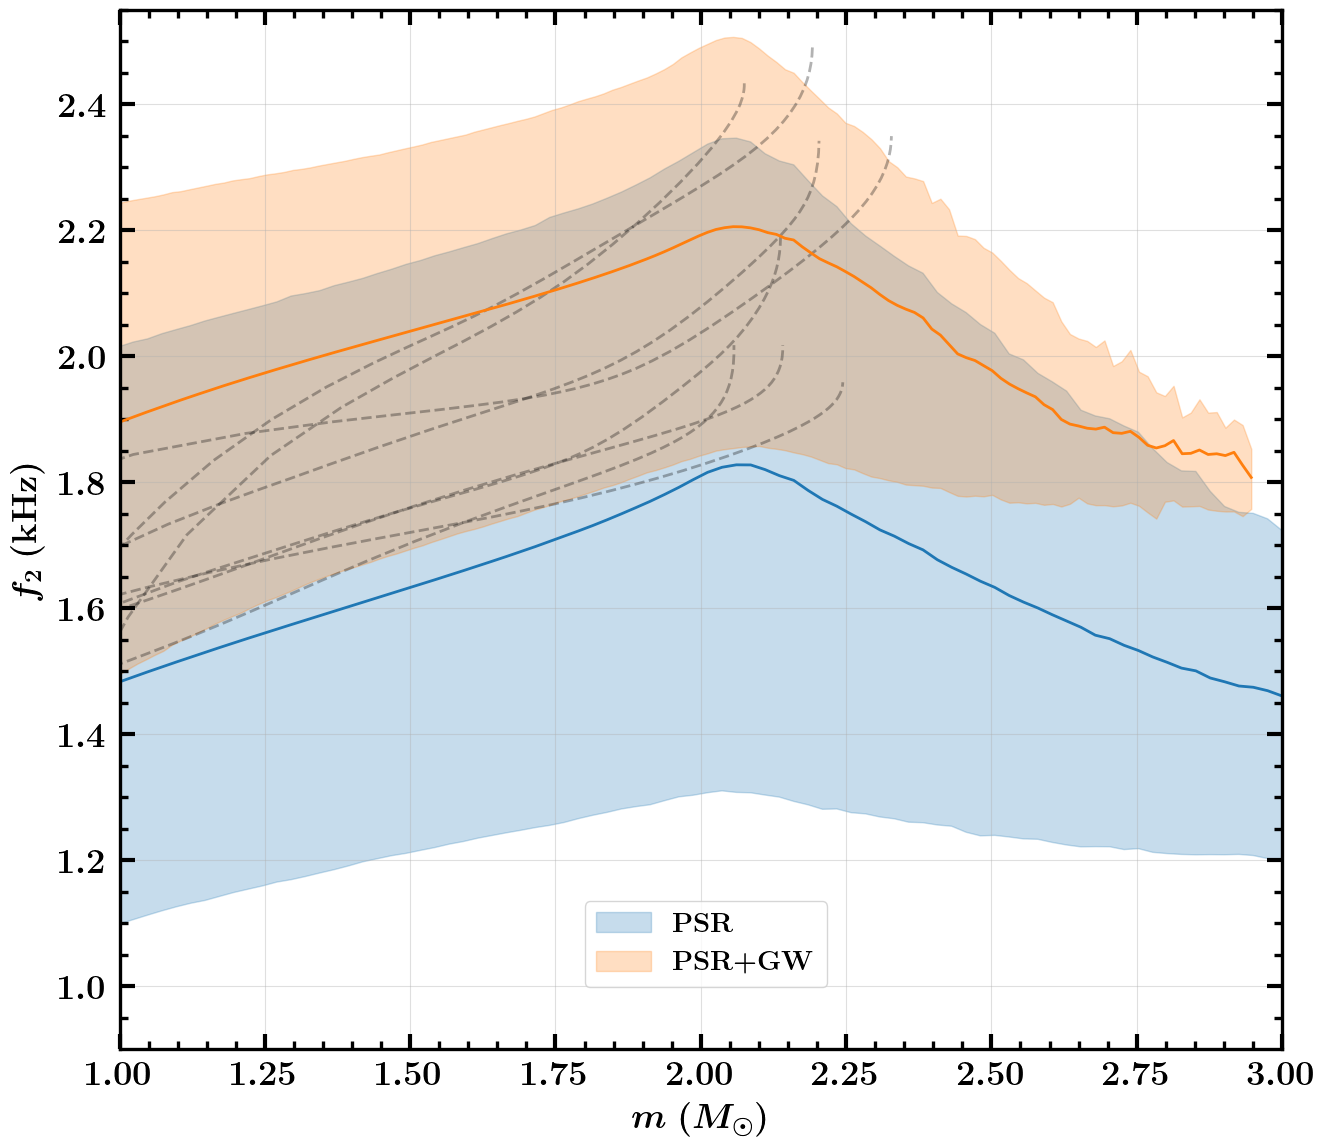

In [11]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

Lables= [r"\bf{PSR}",r"\bf{PSR+GW}",r"\bf{PSR+GW+NICER}"]
Colors= ["tab:blue","tab:orange","tab:green"]

for i in np.linspace(1,9500,8):
    dat= NICER_class.Ensemble_Data["eos_%i" %i]
    plt.plot(dat["M"],dat["f"],"--",color="black",alpha=0.3,linewidth=2)

for i,CI in enumerate(CIs):
    if i in [0,1]:
        M_array,f_mean,f_pls,f_minus= CI
        ax.plot(M_array,f_mean, linewidth= 2, linestyle="-",color=Colors[i])
        ax.fill_between(M_array,f_pls,f_minus,alpha=0.25,color=Colors[i],label=Lables[i])

ax.legend(loc=(0.4,0.06), prop={"size":20})

ax.set_xlim(1,3)
ax.set_ylim(0.9,2.55)

ax.grid(alpha = 0.4)
ax.set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax.set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/Envelope_plot1.pdf", bbox_inches='tight')

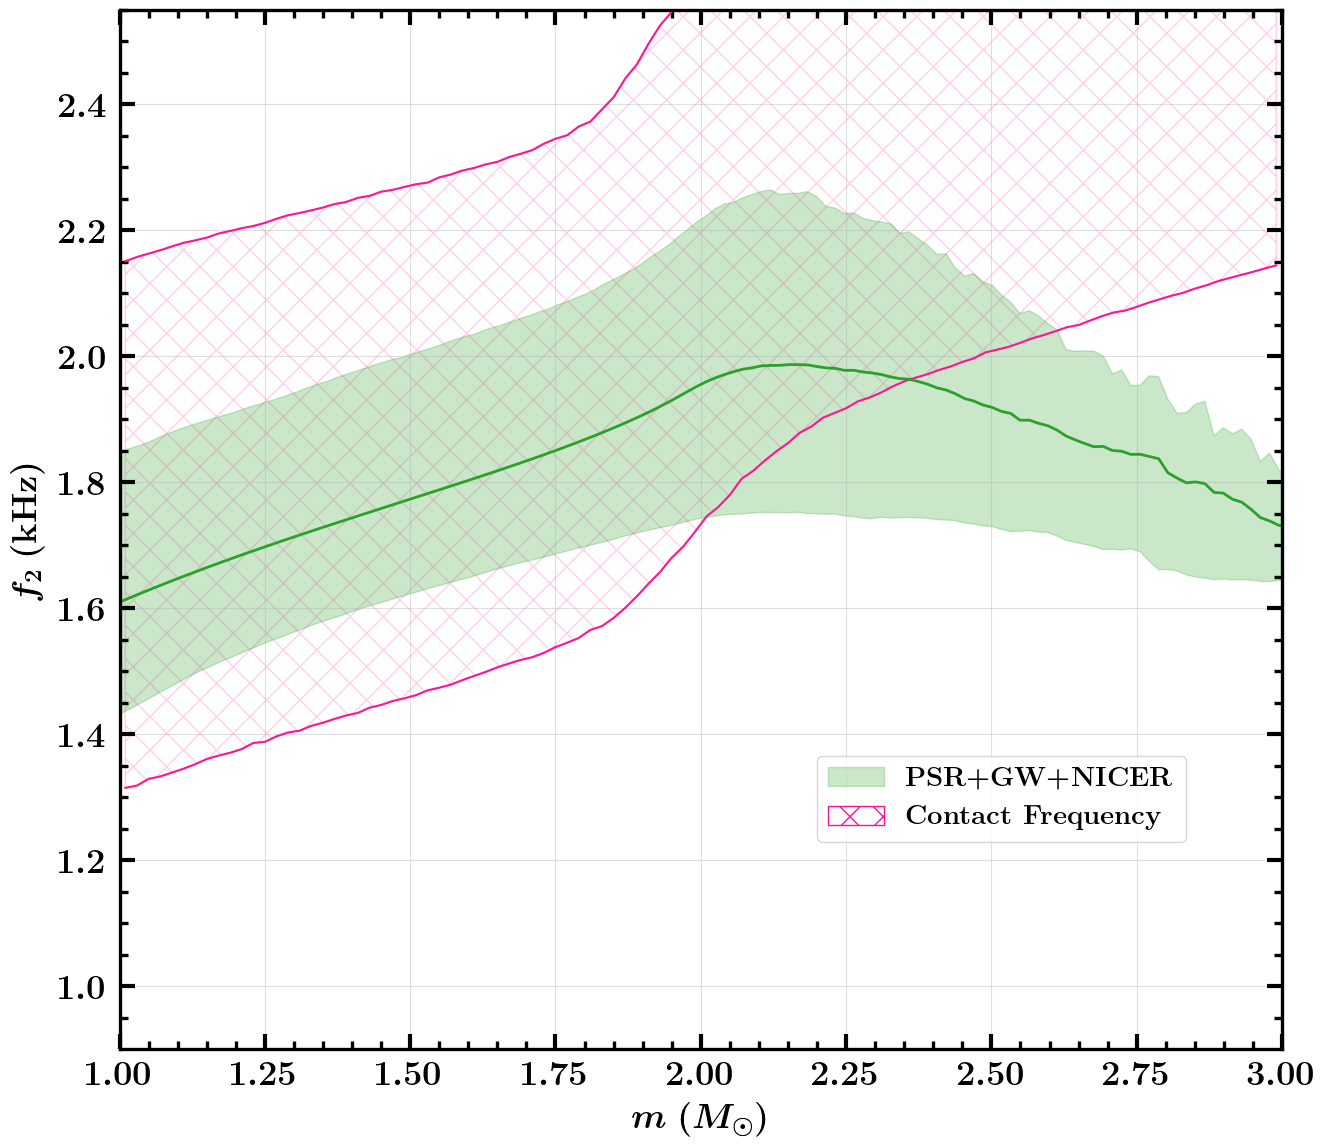

In [110]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

Lables= [r"\bf{PSR}",r"\bf{PSR+GW}",r"\bf{PSR+GW+NICER}"]
Colors= ["tab:blue","tab:orange","tab:green"]

df= pd.read_csv("contact_BNS.csv")
m= np.array(df["m1"])
f= np.array(df["f_contact"])/1000
f= f[np.argsort(m)]
m= np.sort(m)

M= np.linspace(min(m),max(m),101)
f_min= []
f_max= []
k=0
for i in range(len(M)-1):
    f_store=[]
    for j in range(k,len(m)):
        if M[i]<m[j]<M[i+1]:
            f_store.append(f[j])
        elif m[j]>M[i+1]:
            k=j
            break
    f_min.append(min(f_store))
    f_max.append(max(f_store))

M= (M[:-1] + M[1:]) / 2    

ax.plot(M,f_min,color="deeppink")
ax.plot(M,f_max,color="deeppink")
ax.fill(np.concatenate([M,M[::-1]]),np.concatenate([f_min,f_max[::-1]]),color="deeppink",edgecolor="deeppink",facecolor="none",alpha=0.2,hatch="\/")

for i,CI in enumerate(CIs):
    if i==2:
        M_array,f_mean,f_pls,f_minus= CI
        ax.plot(M_array,f_mean, linewidth= 2, linestyle="-",color=Colors[i])
        ax.fill_between(M_array,f_pls,f_minus,alpha=0.25,color=Colors[i],label=Lables[i])

ax.fill_between([],[],[],color="none",hatch="\/",edgecolor="deeppink",label=r"\bf{Contact Frequency}")


ax.legend(loc=(0.6,0.2), prop={"size":20})

ax.set_xlim(1,3)
ax.set_ylim(0.9,2.55)

ax.grid(alpha = 0.4)
ax.set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax.set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/Envelope_plot2.pdf", bbox_inches='tight')

# [Max,1.4] mass NS corner plot

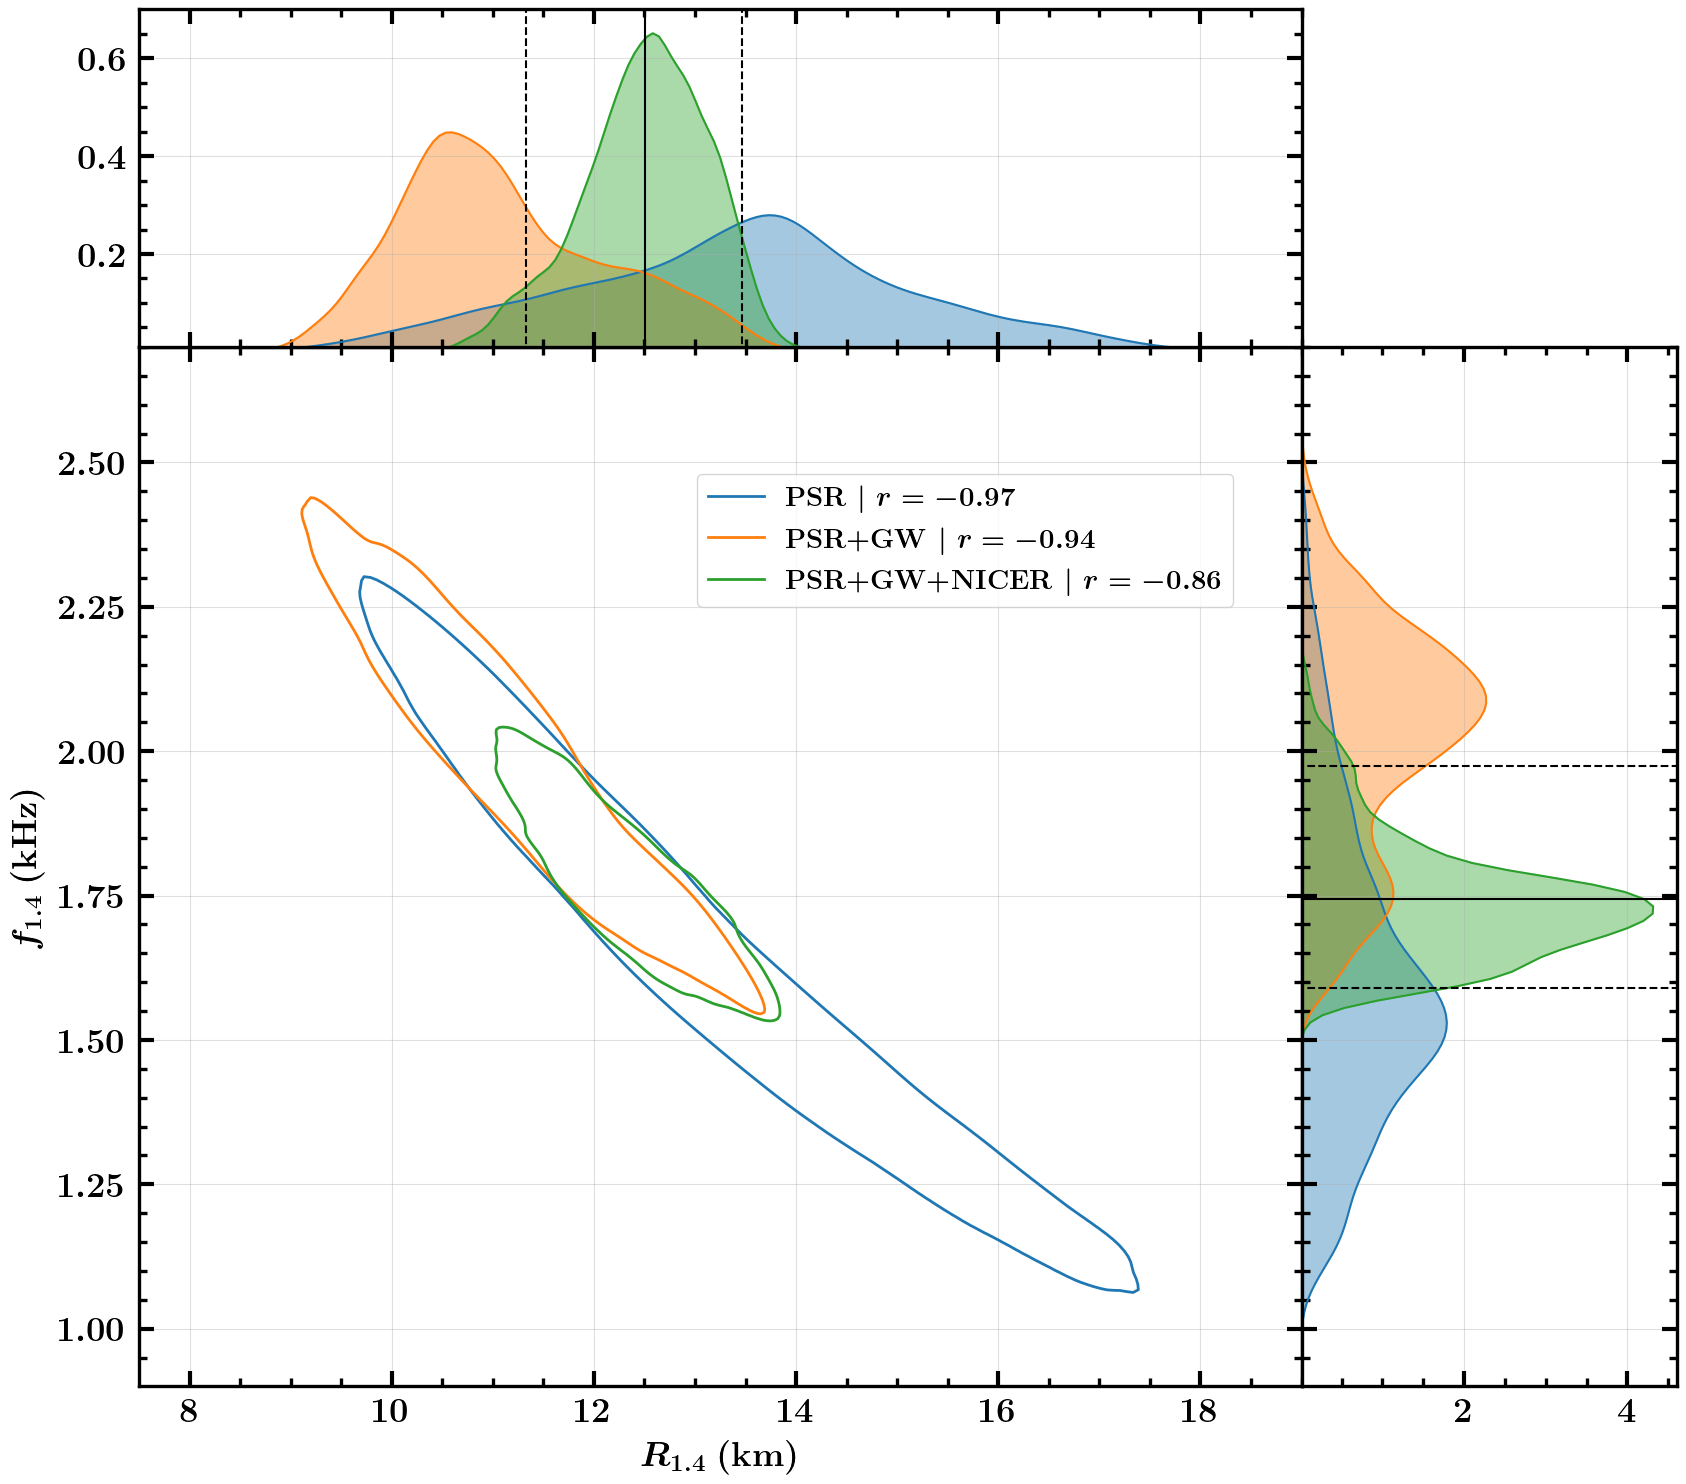

In [121]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

x1,y1,x2,y2=np.concatenate(np.array(ax.get_position()))
axr= fig.add_axes([x2, y1, 0.25, y2-y1])
axt= fig.add_axes([x1, y2, x2-x1, 0.25])
ax.sharex(axt)
ax.sharey(axr)
plt.setp(axr.get_yticklabels(), visible=False)
plt.setp(axt.get_xticklabels(), visible=False)

f= np.linspace(0.5,3,200)
R=np.linspace(8,20,200)

pf= st.gaussian_kde(PSR["f_1.4"])(f)
pr= st.gaussian_kde(PSR["R_1.4"])(R)

axr.plot(pf,f,color="tab:blue")
axr.fill_between(pf,f, alpha=0.4, color= "tab:blue")
axt.plot(R,pr,color="tab:blue")
axt.fill_between(R,pr, alpha=0.4, color= "tab:blue")

pf= st.gaussian_kde(GW["f_1.4"])(f)
pr= st.gaussian_kde(GW["R_1.4"])(R)

axr.plot(pf,f,color="tab:orange")
axr.fill_between(pf,f, alpha=0.4, color= "tab:orange")
axt.plot(R,pr,color="tab:orange")
axt.fill_between(R,pr, alpha=0.4, color= "tab:orange")

pf= st.gaussian_kde(NICER["f_1.4"])(f)
pr= st.gaussian_kde(NICER["R_1.4"])(R)

axr.plot(pf,f,color="tab:green")
axr.fill_between(pf,f, alpha=0.4, color= "tab:green")
axt.plot(R,pr,color="tab:green")
axt.fill_between(R,pr, alpha=0.4, color= "tab:green")

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_1.4"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(NICER["R_1.4"])(R),0.9,typ="mean")

for i in range(3):
    if i==1 or i==2:
        axr.hlines(f_dat[i],-1,10,colors="black",linestyle="--")
        axt.vlines(R_dat[i],-1,10,colors="black",linestyle="--")
    else:
        axr.hlines(f_dat[i],-1,10,colors="black")
        axt.vlines(R_dat[i],-1,10,colors="black")
        

sns.kdeplot(x=PSR["R_1.4"],y=PSR["f_1.4"],ax=ax,levels=[0.1],color="tab:blue",linewidths=2) 
sns.kdeplot(x=GW["R_1.4"],y=GW["f_1.4"],ax=ax,levels=[0.1],color="tab:orange",linewidths=2)
sns.kdeplot(x=NICER["R_1.4"],y=NICER["f_1.4"],ax=ax,levels=[0.1],color="tab:green",linewidths=2) 

ax.plot([],[],label=r"\centering \bf{PSR} $| \ r=-0.97$",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW} $| \ r=-0.94$",color="tab:orange", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER} $| \ r=-0.86$",color="tab:green", linewidth= 2)

ax.legend(loc=(0.48,0.75), prop={"size":20})

ax.set_ylim(0.9,2.7)
ax.set_xlim(7.5,19)
axr.set_xlim(0.01,4.6)
axt.set_ylim(0.01,0.7)

ax.grid(alpha = 0.4)
axr.grid(alpha = 0.4)
axt.grid(alpha = 0.4)
ax.set_xlabel(r'$R_{\rm 1.4} \ ({\rm km})$', labelpad= 8)
ax.set_ylabel(r"$f_{\rm 1.4} \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/Canonical_distribution.pdf", bbox_inches='tight')

In [13]:
f_dat= CI_calc(f,st.gaussian_kde(PSR["f_1.4"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(PSR["R_1.4"])(R),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("R=" + error_str(R_dat))

f_dat= CI_calc(f,st.gaussian_kde(GW["f_1.4"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(GW["R_1.4"])(R),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("R=" + error_str(R_dat))

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_1.4"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(NICER["R_1.4"])(R),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("R=" + error_str(R_dat))

f=$1.60^{+0.52}_{-0.41}$
R=$13.44^{+2.92}_{-2.94}$
f=$2.01^{+0.31}_{-0.35}$
R=$11.11^{+1.92}_{-1.48}$
f=$1.74^{+0.23}_{-0.15}$
R=$12.51^{+0.95}_{-1.18}$


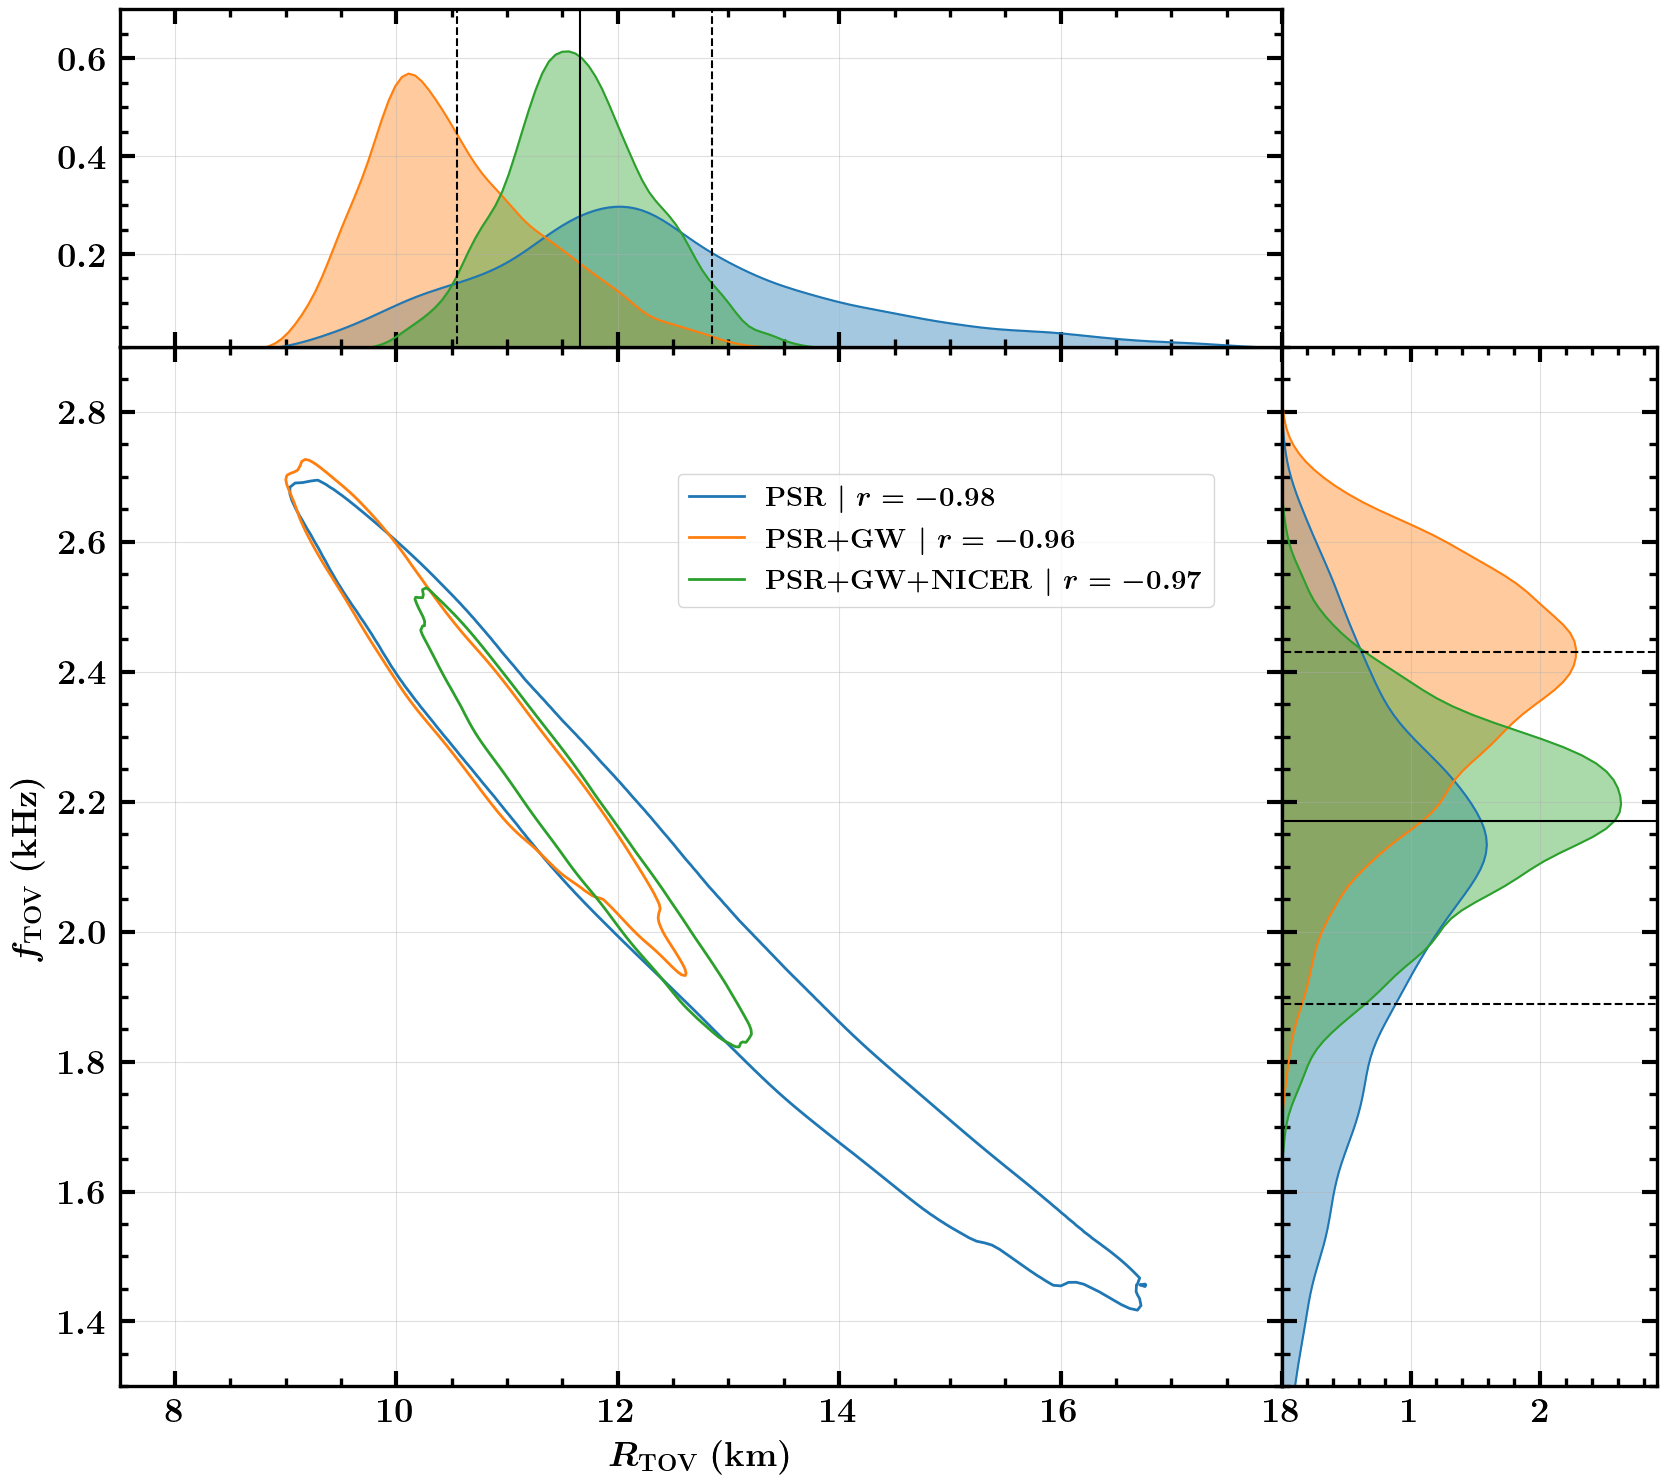

In [120]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

x1,y1,x2,y2=np.concatenate(np.array(ax.get_position()))
axr= fig.add_axes([x2, y1, 0.25, y2-y1])
axt= fig.add_axes([x1, y2, x2-x1, 0.25])
ax.sharex(axt)
ax.sharey(axr)
plt.setp(axr.get_yticklabels(), visible=False)
plt.setp(axt.get_xticklabels(), visible=False)

f= np.linspace(0.5,3,200)
R=np.linspace(8,20,200)

pf= st.gaussian_kde(PSR["f_max"])(f)
pr= st.gaussian_kde(PSR["R_max"])(R)

axr.plot(pf,f,color="tab:blue")
axr.fill_between(pf,f, alpha=0.4, color= "tab:blue")
axt.plot(R,pr,color="tab:blue")
axt.fill_between(R,pr, alpha=0.4, color= "tab:blue")

pf= st.gaussian_kde(GW["f_max"])(f)
pr= st.gaussian_kde(GW["R_max"])(R)

axr.plot(pf,f,color="tab:orange")
axr.fill_between(pf,f, alpha=0.4, color= "tab:orange")
axt.plot(R,pr,color="tab:orange")
axt.fill_between(R,pr, alpha=0.4, color= "tab:orange")

pf= st.gaussian_kde(NICER["f_max"])(f)
pr= st.gaussian_kde(NICER["R_max"])(R)

axr.plot(pf,f,color="tab:green")
axr.fill_between(pf,f, alpha=0.4, color= "tab:green")
axt.plot(R,pr,color="tab:green")
axt.fill_between(R,pr, alpha=0.4, color= "tab:green")

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_max"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(NICER["R_max"])(R),0.9,typ="mean")

for i in range(3):
    if i==1 or i==2:
        axr.hlines(f_dat[i],-1,10,colors="black",linestyle="--")
        axt.vlines(R_dat[i],-1,10,colors="black",linestyle="--")
    else:
        axr.hlines(f_dat[i],-1,10,colors="black")
        axt.vlines(R_dat[i],-1,10,colors="black")
        

sns.kdeplot(x=PSR["R_max"],y=PSR["f_max"],ax=ax,levels=[0.1],color="tab:blue",linewidths=2) 
sns.kdeplot(x=GW["R_max"],y=GW["f_max"],ax=ax,levels=[0.1],color="tab:orange",linewidths=2)
sns.kdeplot(x=NICER["R_max"],y=NICER["f_max"],ax=ax,levels=[0.1],color="tab:green",linewidths=2) 

ax.plot([],[],label=r"\centering \bf{PSR} $| \ r=-0.98$",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW} $| \ r=-0.96$",color="tab:orange", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER} $| \ r=-0.97$",color="tab:green", linewidth= 2)

ax.legend(loc=(0.48,0.75), prop={"size":20})

ax.set_ylim(1.3,2.9)
ax.set_xlim(7.5,18)
axr.set_xlim(0.01,2.9)
axt.set_ylim(0.01,0.7)

ax.grid(alpha = 0.4)
axr.grid(alpha = 0.4)
axt.grid(alpha = 0.4)
ax.set_xlabel(r'$R_{\rm TOV} \ ({\rm km})$', labelpad= 8)
ax.set_ylabel(r"$f_{\rm TOV} \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/TOV_max_lim_Radius.pdf", bbox_inches='tight')

In [14]:
f_dat= CI_calc(f,st.gaussian_kde(PSR["f_max"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(PSR["R_max"])(R),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("R=" + error_str(R_dat))

f_dat= CI_calc(f,st.gaussian_kde(GW["f_max"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(GW["R_max"])(R),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("R=" + error_str(R_dat))

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_max"])(f),0.9,typ="mean")
R_dat= CI_calc(R,st.gaussian_kde(NICER["R_max"])(R),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("R=" + error_str(R_dat))

f=$2.06^{+0.46}_{-0.55}$
R=$12.47^{+3.48}_{-2.48}$
f=$2.37^{+0.27}_{-0.34}$
R=$10.58^{+1.59}_{-1.16}$
f=$2.17^{+0.26}_{-0.28}$
R=$11.66^{+1.19}_{-1.11}$


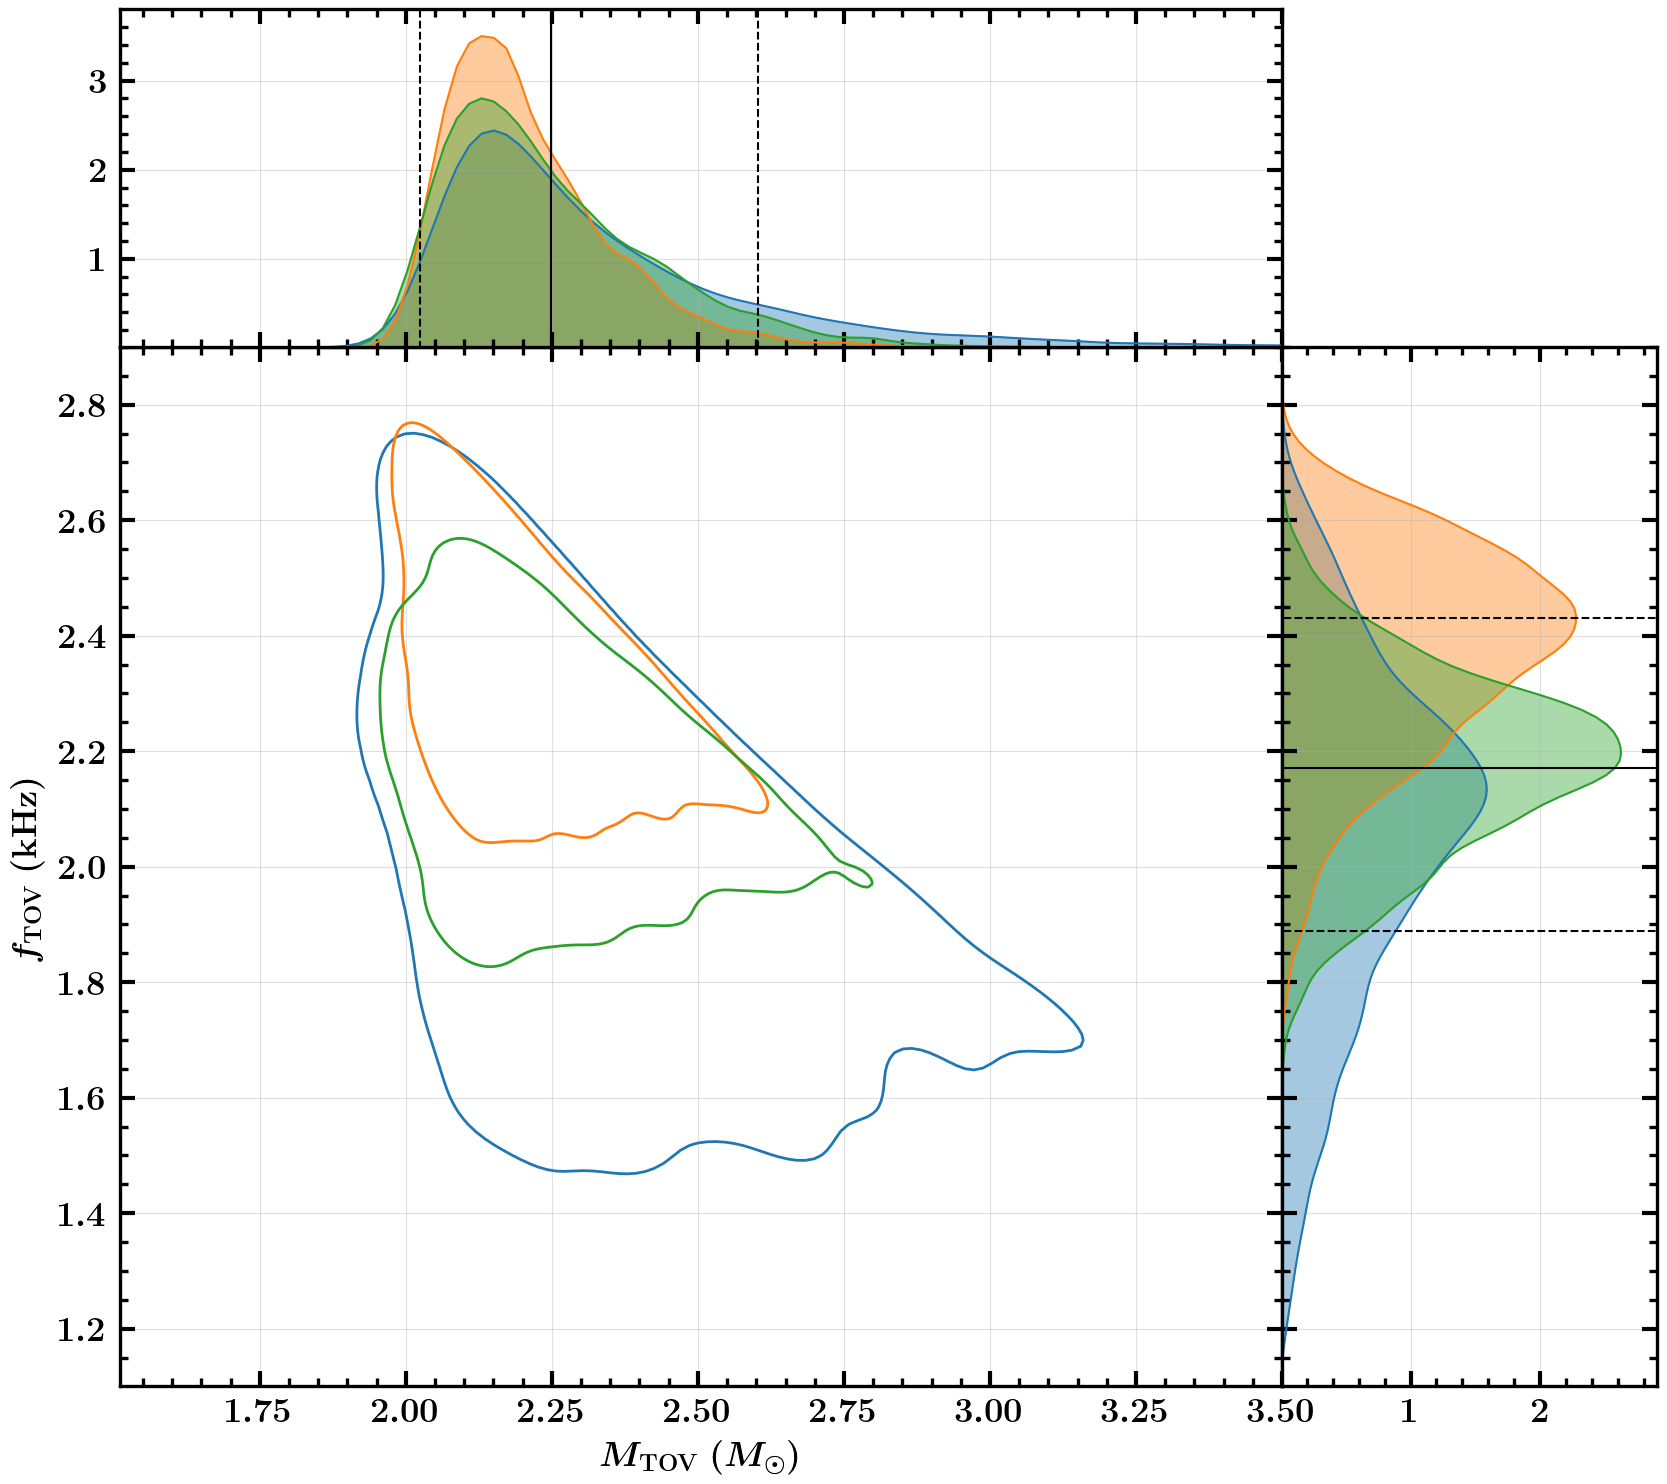

In [156]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

x1,y1,x2,y2=np.concatenate(np.array(ax.get_position()))
axr= fig.add_axes([x2, y1, 0.25, y2-y1])
axt= fig.add_axes([x1, y2, x2-x1, 0.25])
ax.sharex(axt)
ax.sharey(axr)
plt.setp(axr.get_yticklabels(), visible=False)
plt.setp(axt.get_xticklabels(), visible=False)

f= np.linspace(0.5,3,200)
M=np.linspace(0.8,5,200)

pf= st.gaussian_kde(PSR["f_max"])(f)
pM= st.gaussian_kde(PSR["M_max"])(M)

axr.plot(pf,f,color="tab:blue")
axr.fill_between(pf,f, alpha=0.4, color= "tab:blue")
axt.plot(M,pM, color="tab:blue")
axt.fill_between(M,pM, alpha=0.4, color= "tab:blue")

pf= st.gaussian_kde(GW["f_max"])(f)
pM= st.gaussian_kde(GW["M_max"])(M)

axr.plot(pf,f,color="tab:orange")
axr.fill_between(pf,f, alpha=0.4, color= "tab:orange")
axt.plot(M,pM, color="tab:orange")
axt.fill_between(M,pM, alpha=0.4, color= "tab:orange")

pf= st.gaussian_kde(NICER["f_max"])(f)
pM= st.gaussian_kde(NICER["M_max"])(M)

axr.plot(pf,f,color="tab:green")
axr.fill_between(pf,f, alpha=0.4, color= "tab:green")
axt.plot(M,pM, color="tab:green")
axt.fill_between(M,pM, alpha=0.4, color= "tab:green")

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_max"])(f),0.9,typ="mean")
M_dat= CI_calc(M,st.gaussian_kde(NICER["M_max"])(M),0.9,typ="mean")

for i in range(3):
    if i==1 or i==2:
        axr.hlines(f_dat[i],-1,10,colors="black",linestyle="--")
        axt.vlines(M_dat[i],-1,10,colors="black",linestyle="--")
    else:
        axr.hlines(f_dat[i],-1,10,colors="black")
        axt.vlines(M_dat[i],-1,10,colors="black")
        
sns.kdeplot(x=PSR["M_max"],y=PSR["f_max"],ax=ax,levels=[0.1],color="tab:blue",linewidths=2) 
sns.kdeplot(x=GW["M_max"],y=GW["f_max"],ax=ax,levels=[0.1],color="tab:orange",linewidths=2)
sns.kdeplot(x=NICER["M_max"],y=NICER["f_max"],ax=ax,levels=[0.1],color="tab:green",linewidths=2) 

ax.plot([],[],label=r"\bf{PSR}",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="tab:orange", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="tab:green", linewidth= 2)

# ax.legend(loc=(0.6,0.74), prop={"size":15})

ax.set_ylim(1.1,2.9)
ax.set_xlim(1.51,3.5)
axr.set_xlim(0.01,2.9)
axt.set_ylim(0.01,3.8)

ax.grid(alpha = 0.4)
axr.grid(alpha = 0.4)
axt.grid(alpha = 0.4)

ax.set_xlabel(r'$M_{\rm TOV} \ (M_\odot)$', labelpad= 8)
ax.set_ylabel(r"$f_{\rm TOV} \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/TOV_max_lim.pdf", bbox_inches='tight')

In [155]:
f_dat= CI_calc(f,st.gaussian_kde(PSR["f_max"])(f),0.9,typ="mean")
M_dat= CI_calc(M,st.gaussian_kde(PSR["M_max"])(M),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("M=" + error_str(M_dat))

f_dat= CI_calc(f,st.gaussian_kde(GW["f_max"])(f),0.9,typ="mean")
M_dat= CI_calc(M,st.gaussian_kde(GW["M_max"])(M),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("M=" + error_str(M_dat))

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_max"])(f),0.9,typ="mean")
M_dat= CI_calc(M,st.gaussian_kde(NICER["M_max"])(M),0.9,typ="mean")

print("f=" + error_str(f_dat))
print("M=" + error_str(M_dat))

f=$2.06^{+0.46}_{-0.55}$
M=$2.33^{+0.59}_{-0.30}$
f=$2.37^{+0.27}_{-0.34}$
M=$2.21^{+0.27}_{-0.18}$
f=$2.17^{+0.26}_{-0.28}$
M=$2.25^{+0.35}_{-0.22}$


In [87]:
df= pd.DataFrame(np.transpose([PSR["M_max"],PSR["R_max"],PSR["f_max"],PSR["R_1.4"],PSR["f_1.4"]]),
                 columns=["$M_{\rm TOV}$","$R_{\rm TOV}$","$f_{\rm TOV}$","$R_{\rm 1.4}$","$f_{\rm 1.4}$"])
df.corr()

,$M_{\rm TOV}$,$R_{\rm TOV}$,$f_{\rm TOV}$,$R_{\rm 1.4}$,$f_{\rm 1.4}$
$M_{\rm TOV}$,1.000000,0.620211,-0.582432,0.374754,-0.400123
$R_{\rm TOV}$,0.620211,1.000000,-0.977360,0.809043,-0.828803
$f_{\rm TOV}$,-0.582432,-0.977360,1.000000,-0.727931,0.777805
$R_{\rm 1.4}$,0.374754,0.809043,-0.727931,1.000000,-0.969436
$f_{\rm 1.4}$,-0.400123,-0.828803,0.777805,-0.969436,1.000000


In [90]:
df= pd.DataFrame(np.transpose([GW["M_max"],GW["R_max"],GW["f_max"],GW["R_1.4"],GW["f_1.4"]]),
                 columns=["$M_{\rm TOV}$","$R_{\rm TOV}$","$f_{\rm TOV}$","$R_{\rm 1.4}$","$f_{\rm 1.4}$"])
df.corr()

,$M_{\rm TOV}$,$R_{\rm TOV}$,$f_{\rm TOV}$,$R_{\rm 1.4}$,$f_{\rm 1.4}$
$M_{\rm TOV}$,1.000000,0.498020,-0.580644,0.180150,-0.304939
$R_{\rm TOV}$,0.498020,1.000000,-0.962087,0.789292,-0.864233
$f_{\rm TOV}$,-0.580644,-0.962087,1.000000,-0.606857,0.741895
$R_{\rm 1.4}$,0.180150,0.789292,-0.606857,1.000000,-0.941340
$f_{\rm 1.4}$,-0.304939,-0.864233,0.741895,-0.941340,1.000000


In [91]:
df= pd.DataFrame(np.transpose([NICER["M_max"],NICER["R_max"],NICER["f_max"],NICER["R_1.4"],NICER["f_1.4"]]),
                 columns=["$M_{\rm TOV}$","$R_{\rm TOV}$","$f_{\rm TOV}$","$R_{\rm 1.4}$","$f_{\rm 1.4}$"])
df.corr()

,$M_{\rm TOV}$,$R_{\rm TOV}$,$f_{\rm TOV}$,$R_{\rm 1.4}$,$f_{\rm 1.4}$
$M_{\rm TOV}$,1.000000,0.358017,-0.394282,-0.136391,-0.005047
$R_{\rm TOV}$,0.358017,1.000000,-0.970490,0.417384,-0.586319
$f_{\rm TOV}$,-0.394282,-0.970490,1.000000,-0.211893,0.444625
$R_{\rm 1.4}$,-0.136391,0.417384,-0.211893,1.000000,-0.860036
$f_{\rm 1.4}$,-0.005047,-0.586319,0.444625,-0.860036,1.000000


# GW Events

In [123]:
class GW_posterior:
    def __init__(self,EOS_set): 
        M= EOS_set["M"]
        f= EOS_set["f"]
        self.Mf_kde= st.gaussian_kde([M,f]).pdf
        self.EOS_set= EOS_set
                
    def Event_input(self,M_samples,ID="GW170817",Component=1):
        self.M_samples=M_samples
        self.M_kde= st.gaussian_kde(M_samples)
        self.M_limits= array_from_samp(self.M_samples,2)
        if ID not in self.EOS_set:
            self.EOS_set[ID]=dict()
        self.ID=ID
        self.Component=Component
        return
        
    def prior(self,M,f):
        return self.Mf_kde([M,f])[0]
        
    def likelihood(self,M):
        return self.M_kde(M)
        
    def gen_samp(self,n_grid=150,n_samp=4000):
        
        ID= self.ID
        EOS_set= self.EOS_set
        i= self.Component
        
        print("ID:",ID,"|","Component:",i,"|","EOS:",EOS_set["group_name"])
        
        pdf = lambda M,f: (self.prior(M,f)*self.likelihood(M))[0]
        M_samp,f_samp = sampling_2d(pdf,self.M_limits,[0.5,3],n_grid=n_grid,n_samp=n_samp).generate(self.M_samples)
                
        if i is None:
            EOS_set[ID]["M"]= M_samp
            EOS_set[ID]["f"]= f_samp
        else:
            EOS_set[ID]["M%i" %i]= M_samp
            EOS_set[ID]["f%i" %i]= f_samp
        
        return M_samp,f_samp

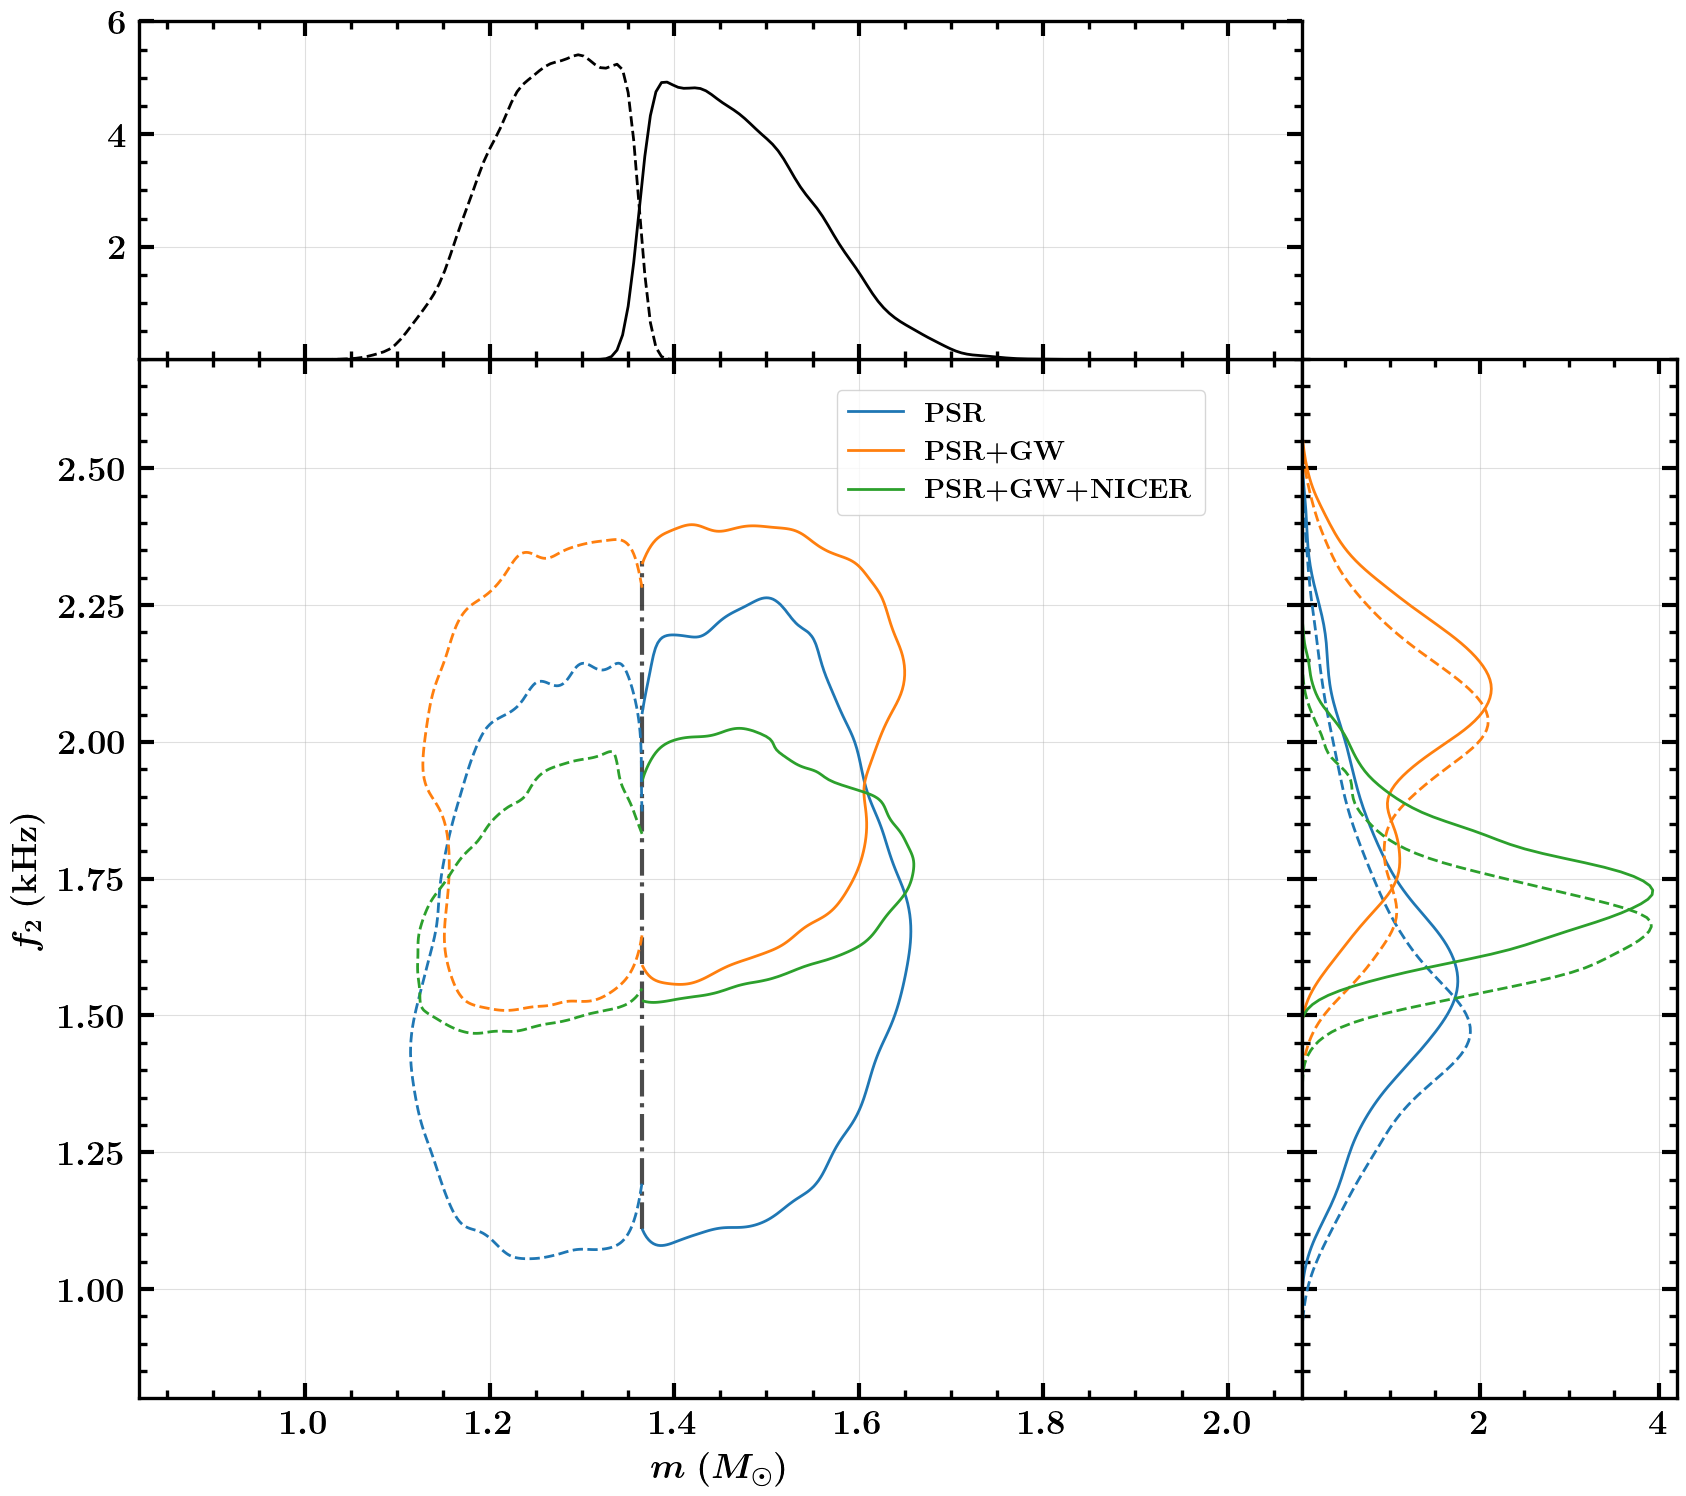

In [144]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

Lables= [r"\bf{PSR}",r"\bf{PSR+GW}",r"\bf{PSR+GW+NICER}"]
Colors= ["tab:blue","tab:orange","tab:green"]

x1,y1,x2,y2=np.concatenate(np.array(ax.get_position()))
axr= fig.add_axes([x2, y1, 0.25, y2-y1])
axt= fig.add_axes([x1, y2, x2-x1, 0.25])
ax.sharex(axt)
ax.sharey(axr)
plt.setp(axr.get_yticklabels(), visible=False)
plt.setp(axt.get_xticklabels(), visible=False)

f= np.linspace(0.5,3,300)
M= np.linspace(0.7,2.5,300)

pf1= st.gaussian_kde(PSR["GW170817"]["f1"])(f)
pf2= st.gaussian_kde(PSR["GW170817"]["f2"])(f)

axr.plot(pf1,f,color="tab:blue", linestyle="-", linewidth=2)
axr.plot(pf2,f,color="tab:blue", linestyle="--", linewidth=2)

pf1= st.gaussian_kde(GW["GW170817"]["f1"])(f)
pf2= st.gaussian_kde(GW["GW170817"]["f2"])(f)

axr.plot(pf1,f,color="tab:orange", linestyle="-", linewidth=2)
axr.plot(pf2,f,color="tab:orange", linestyle="--", linewidth=2)

pf1= st.gaussian_kde(NICER["GW170817"]["f1"])(f)
pf2= st.gaussian_kde(NICER["GW170817"]["f2"])(f)

axr.plot(pf1,f,color="tab:green",linestyle="-", linewidth=2)
# axr.fill_between(pf1,f, alpha=0.4, color="none", edgecolor= "tab:green", hatch="X")
axr.plot(pf2,f,color="tab:green",linestyle="--", linewidth=2)
# axr.fill_between(pf2,f, alpha=0.4, color="none", edgecolor= "tab:green", hatch="X")

pm1= st.gaussian_kde(NICER["GW170817"]["M1"])(M)
pm2= st.gaussian_kde(NICER["GW170817"]["M2"])(M)

for i in range(len(M)):
    if pm1[i]-pm2[i]>0:
        m_bound= (M[i-1] + M[i])/2
        break

axt.plot(M,pm1,color="black",linestyle="-", linewidth=2)
# axt.fill_between(M,pm1, alpha=0.4, color= "tab:blue")
axt.plot(M,pm2,color="black",linestyle="--", linewidth=2)
# axt.fill_between(M,pm2, alpha=0.4, color= "tab:orange")


# f1_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f1"])(f),0.9,typ="mean")
# M1_dat= CI_calc(M,st.gaussian_kde(NICER["GW170817"]["M1"])(M),0.9,typ="mean")
# f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f2"])(f),0.9,typ="mean")
# M2_dat= CI_calc(M,st.gaussian_kde(NICER["GW170817"]["M2"])(M),0.9,typ="mean")

# for i in range(3):
#     if i!=0:
#         axr.hlines(f1_dat[i],-1,10,colors="tab:green",linestyle="-.")
#         axt.vlines(M1_dat[i],-1,10,colors="black",linestyle="-.")
#         axr.hlines(f2_dat[i],-1,10,colors="tab:green",linestyle="-.")
#         axt.vlines(M2_dat[i],-1,10,colors="black",linestyle="-.")
        

ax.plot([m_bound,m_bound],[1.11,2.33],linewidth=3,linestyle="-.",color="black",alpha=0.7)

sns.kdeplot(x=PSR["GW170817"]["M1"],y=PSR["GW170817"]["f1"],ax=ax,levels=[0.1],
            color="tab:blue",linewidths=2,linestyles="-", clip=[[m_bound,3],[0,5]]) 
sns.kdeplot(x=GW["GW170817"]["M1"],y=GW["GW170817"]["f1"],ax=ax,levels=[0.1],
            color="tab:orange",linewidths=2,linestyles="-", clip=[[m_bound,3],[0,5]])
sns.kdeplot(x=NICER["GW170817"]["M1"],y=NICER["GW170817"]["f1"],ax=ax,levels=[0.1],
            color="tab:green",linewidths=2,linestyles="-", clip=[[m_bound,3],[0,5]]) 

sns.kdeplot(x=PSR["GW170817"]["M2"],y=PSR["GW170817"]["f2"],ax=ax,levels=[0.1],
            color="tab:blue",linewidths=2,linestyles="--", clip=[[0,m_bound],[0,5]]) 
sns.kdeplot(x=GW["GW170817"]["M2"],y=GW["GW170817"]["f2"],ax=ax,levels=[0.1],
            color="tab:orange",linewidths=2,linestyles="--", clip=[[0,m_bound],[0,5]])
sns.kdeplot(x=NICER["GW170817"]["M2"],y=NICER["GW170817"]["f2"],ax=ax,levels=[0.1],
            color="tab:green",linewidths=2,linestyles="--", clip=[[0,m_bound],[0,5]]) 

ax.plot([],[],label=r"\bf{PSR}",color="tab:blue", linestyle="-", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="tab:orange", linestyle="-", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="tab:green", linestyle="-", linewidth= 2)

ax.legend(loc=(0.6,0.85), prop={"size":20})

ax.set_ylim(0.8,2.7)
ax.set_xlim(0.82,2.08)
axr.set_xlim(0.01,4.2)
axt.set_ylim(0.01,6)

ax.grid(alpha = 0.4)
axr.grid(alpha = 0.4)
axt.grid(alpha = 0.4)

ax.set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax.set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/GW170817_2D_posterior.pdf", bbox_inches='tight')

In [162]:
f1_dat= CI_calc(f,st.gaussian_kde(PSR["GW170817"]["f1"])(f),0.9,typ="mean")
M1_dat= CI_calc(M,st.gaussian_kde(PSR["GW170817"]["M1"])(M),0.9,typ="mean")
f2_dat= CI_calc(f,st.gaussian_kde(PSR["GW170817"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(PSR["GW170817"]["M2"])(M),0.9,typ="mean")

print("M1=" + error_str(M1_dat))
print("f1=" + error_str(f1_dat))
print("M2=" + error_str(M2_dat))
print("f2=" + error_str(f2_dat))

M1=$1.48^{+0.14}_{-0.11}$
f1=$1.63^{+0.52}_{-0.41}$
M2=$1.26^{+0.09}_{-0.11}$
f2=$1.56^{+0.52}_{-0.39}$


In [163]:
f1_dat= CI_calc(f,st.gaussian_kde(GW["GW170817"]["f1"])(f),0.9,typ="mean")
M1_dat= CI_calc(M,st.gaussian_kde(GW["GW170817"]["M1"])(M),0.9,typ="mean")
f2_dat= CI_calc(f,st.gaussian_kde(GW["GW170817"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(GW["GW170817"]["M2"])(M),0.9,typ="mean")

print("M1=" + error_str(M1_dat))
print("f1=" + error_str(f1_dat))
print("M2=" + error_str(M2_dat))
print("f2=" + error_str(f2_dat))

M1=$1.48^{+0.14}_{-0.11}$
f1=$2.02^{+0.31}_{-0.36}$
M2=$1.26^{+0.09}_{-0.11}$
f2=$1.95^{+0.34}_{-0.38}$


In [164]:
f1_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f1"])(f),0.9,typ="mean")
M1_dat= CI_calc(M,st.gaussian_kde(NICER["GW170817"]["M1"])(M),0.9,typ="mean")
f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(NICER["GW170817"]["M2"])(M),0.9,typ="mean")

print("M1=" + error_str(M1_dat))
print("f1=" + error_str(f1_dat))
print("M2=" + error_str(M2_dat))
print("f2=" + error_str(f2_dat))

M1=$1.48^{+0.14}_{-0.11}$
f1=$1.75^{+0.23}_{-0.16}$
M2=$1.26^{+0.09}_{-0.11}$
f2=$1.68^{+0.24}_{-0.16}$


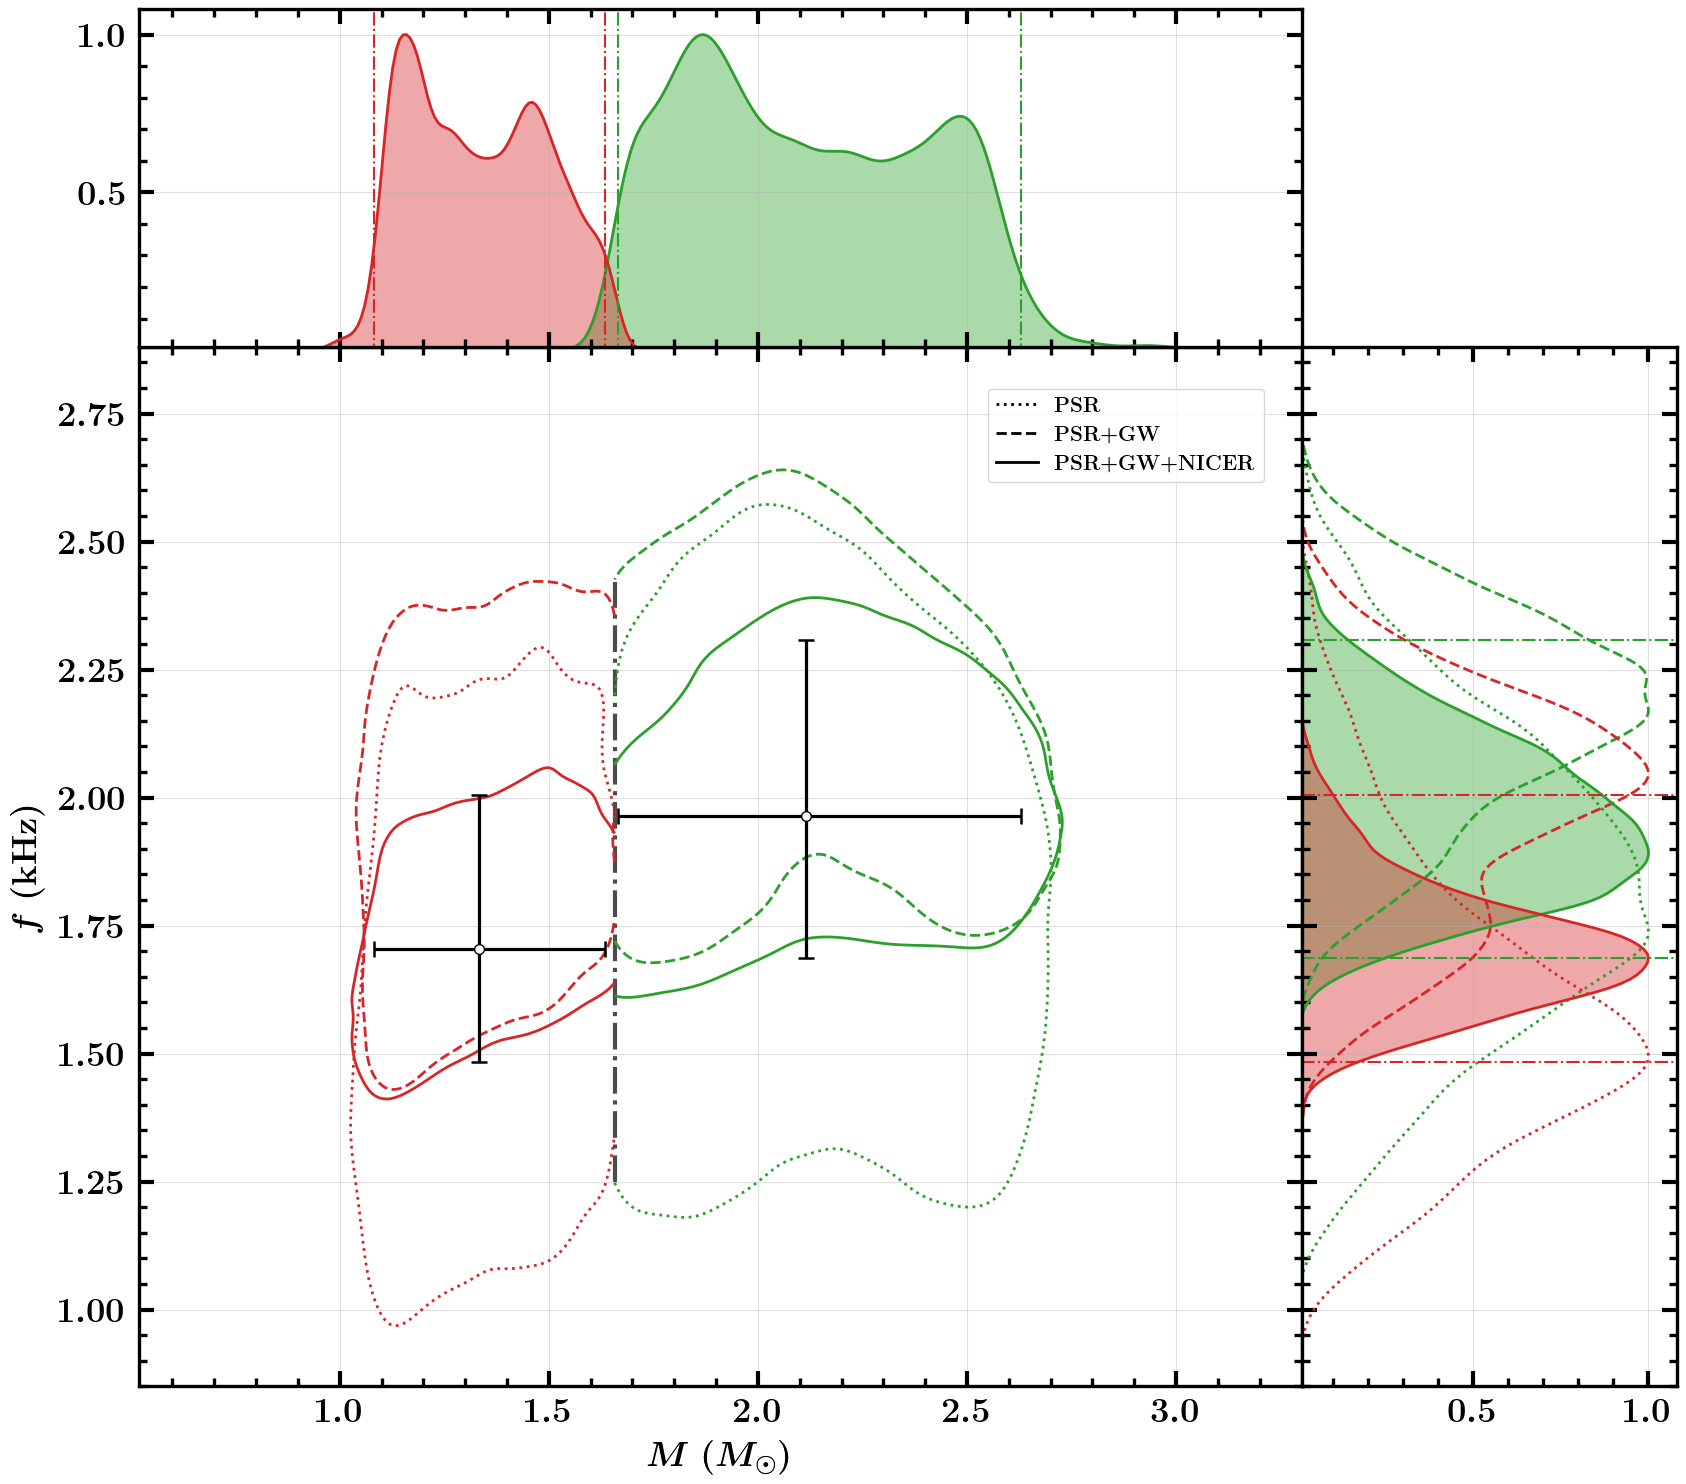

In [116]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

x1,y1,x2,y2=np.concatenate(np.array(ax.get_position()))
axr= fig.add_axes([x2, y1, 0.25, y2-y1])
axt= fig.add_axes([x1, y2, x2-x1, 0.25])
ax.sharex(axt)
ax.sharey(axr)
plt.setp(axr.get_yticklabels(), visible=False)
plt.setp(axt.get_xticklabels(), visible=False)

f= np.linspace(0.5,3,300)
M=np.linspace(0.7,3.2,300)

pf1= st.gaussian_kde(PSR["GW190425"]["f1"])(f)
pf2= st.gaussian_kde(PSR["GW190425"]["f2"])(f)

axr.plot(pf1/max(pf1),f,color="tab:green", linestyle=":", linewidth=2)
axr.plot(pf2/max(pf2),f,color="tab:red", linestyle=":", linewidth=2)

pf1= st.gaussian_kde(GW["GW190425"]["f1"])(f)
pf2= st.gaussian_kde(GW["GW190425"]["f2"])(f)

axr.plot(pf1/max(pf1),f,color="tab:green", linestyle="--", linewidth=2)
axr.plot(pf2/max(pf2),f,color="tab:red", linestyle="--", linewidth=2)

pf1= st.gaussian_kde(NICER["GW190425"]["f1"])(f)
pf2= st.gaussian_kde(NICER["GW190425"]["f2"])(f)

axr.plot(pf1/max(pf1),f,color="tab:green",linestyle="-", linewidth=2)
axr.fill_between(pf1/max(pf1),f, alpha=0.4, color= "tab:green")
axr.plot(pf2/max(pf2),f,color="tab:red",linestyle="-", linewidth=2)
axr.fill_between(pf2/max(pf2),f, alpha=0.4, color= "tab:red")

pm1= st.gaussian_kde(NICER["GW190425"]["M1"])(M)
pm2= st.gaussian_kde(NICER["GW190425"]["M2"])(M)

for i in range(len(M)):
    if pm1[i]-pm2[i]>0:
        m_bound= (M[i-1] + M[i])/2
        break

axt.plot(M,pm1/max(pm1),color="tab:green",linestyle="-", linewidth=2)
axt.fill_between(M,pm1/max(pm1), alpha=0.4, color= "tab:green")
axt.plot(M,pm2/max(pm2),color="tab:red",linestyle="-", linewidth=2)
axt.fill_between(M,pm2/max(pm2), alpha=0.4, color= "tab:red")


f1_dat= CI_calc(f,st.gaussian_kde(NICER["GW190425"]["f1"])(f),0.95,typ="mean")
M1_dat= CI_calc(M,st.gaussian_kde(NICER["GW190425"]["M1"])(M),0.95,typ="mean")
f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW190425"]["f2"])(f),0.95,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(NICER["GW190425"]["M2"])(M),0.95,typ="mean")

for i in range(3):
    if i!=0:
        axr.hlines(f1_dat[i],-1,10,colors="tab:green",linestyle="-.")
        axt.vlines(M1_dat[i],-1,10,colors="tab:green",linestyle="-.")
        axr.hlines(f2_dat[i],-1,10,colors="tab:red",linestyle="-.")
        axt.vlines(M2_dat[i],-1,10,colors="tab:red",linestyle="-.")
        
for M_dat,f_dat in zip([M1_dat,M2_dat],[f1_dat,f2_dat]):
    ax.errorbar(M_dat[0],f_dat[0],
                xerr=[[M_dat[0]-M_dat[2]],[M_dat[1]-M_dat[0]]],yerr= [[f_dat[0]-f_dat[2]],[f_dat[1]-f_dat[0]]], 
                zorder=100,          
                color="black",
                capsize=6, 
                markersize=7,
                mfc="white",
                capthick=1.8,
                linewidth= 2.3,
                fmt= "o")
    
ax.plot([m_bound,m_bound],[1.25,2.42],linewidth=3,linestyle="-.",color="black",alpha=0.7)

sns.kdeplot(x=PSR["GW190425"]["M1"],y=PSR["GW190425"]["f1"],ax=ax,levels=[0.05],
            color="tab:green",linewidths=2,linestyles=":", clip=[[m_bound,3],[0,5]]) 
sns.kdeplot(x=GW["GW190425"]["M1"],y=GW["GW190425"]["f1"],ax=ax,levels=[0.05],
            color="tab:green",linewidths=2,linestyles="--", clip=[[m_bound,3],[0,5]])
sns.kdeplot(x=NICER["GW190425"]["M1"],y=NICER["GW190425"]["f1"],ax=ax,levels=[0.05],
            color="tab:green",linewidths=2,linestyles="-", clip=[[m_bound,3],[0,5]]) 

sns.kdeplot(x=PSR["GW190425"]["M2"],y=PSR["GW190425"]["f2"],ax=ax,levels=[0.05],
            color="tab:red",linewidths=2,linestyles=":", clip=[[0,m_bound],[0,5]]) 
sns.kdeplot(x=GW["GW190425"]["M2"],y=GW["GW190425"]["f2"],ax=ax,levels=[0.05],
            color="tab:red",linewidths=2,linestyles="--", clip=[[0,m_bound],[0,5]])
sns.kdeplot(x=NICER["GW190425"]["M2"],y=NICER["GW190425"]["f2"],ax=ax,levels=[0.05],
            color="tab:red",linewidths=2,linestyles="-", clip=[[0,m_bound],[0,5]]) 

ax.plot([],[],label=r"\bf{PSR}",color="black", linestyle=":", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="black", linestyle="--", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="black", linestyle="-", linewidth= 2)

ax.legend(loc=(0.73,0.87), prop={"size":15})

ax.set_ylim(0.85,2.88)
ax.set_xlim(0.52,3.3)
axr.set_xlim(0.01,1.08)
axt.set_ylim(0.01,1.08)

ax.grid(alpha = 0.4)
axr.grid(alpha = 0.4)
axt.grid(alpha = 0.4)

ax.set_xlabel(r'$M \ (M_\odot)$', labelpad= 8)
ax.set_ylabel(r"$f \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/GW190425_2D_posterior.pdf", bbox_inches='tight')

In [165]:
f= np.linspace(0.5,3,300)
M=np.linspace(0.7,3.2,300)

In [172]:
f1_dat= CI_calc(f,st.gaussian_kde(PSR["GW190425"]["f1"])(f),0.9,typ="mean")
M1_dat= CI_calc(M,st.gaussian_kde(PSR["GW190425"]["M1"])(M),0.9,typ="mean")
f2_dat= CI_calc(f,st.gaussian_kde(PSR["GW190425"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(PSR["GW190425"]["M2"])(M),0.9,typ="mean")

print("M1=" + error_str(M1_dat))
print("f1=" + error_str(f1_dat))
print("M2=" + error_str(M2_dat))
print("f2=" + error_str(f2_dat))

M1=$2.12^{+0.46}_{-0.42}$
f1=$1.84^{+0.50}_{-0.50}$
M2=$1.33^{+0.27}_{-0.23}$
f2=$1.58^{+0.54}_{-0.42}$


In [173]:
f1_dat= CI_calc(f,st.gaussian_kde(GW["GW190425"]["f1"])(f),0.9,typ="mean")
M1_dat= CI_calc(M,st.gaussian_kde(GW["GW190425"]["M1"])(M),0.9,typ="mean")
f2_dat= CI_calc(f,st.gaussian_kde(GW["GW190425"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(GW["GW190425"]["M2"])(M),0.9,typ="mean")

print("M1=" + error_str(M1_dat))
print("f1=" + error_str(f1_dat))
print("M2=" + error_str(M2_dat))
print("f2=" + error_str(f2_dat))

M1=$2.12^{+0.46}_{-0.42}$
f1=$2.16^{+0.32}_{-0.35}$
M2=$1.33^{+0.27}_{-0.23}$
f2=$1.97^{+0.34}_{-0.38}$


In [171]:
f1_dat= CI_calc(f,st.gaussian_kde(NICER["GW190425"]["f1"])(f),0.9,typ="mean")
M1_dat= CI_calc(M,st.gaussian_kde(NICER["GW190425"]["M1"])(M),0.9,typ="mean")
f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW190425"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(NICER["GW190425"]["M2"])(M),0.9,typ="mean")

print("M1=" + error_str(M1_dat))
print("f1=" + error_str(f1_dat))
print("M2=" + error_str(M2_dat))
print("f2=" + error_str(f2_dat))

M1=$2.12^{+0.46}_{-0.42}$
f1=$1.96^{+0.29}_{-0.24}$
M2=$1.33^{+0.27}_{-0.23}$
f2=$1.70^{+0.24}_{-0.19}$


# 1D distribtuion Plots

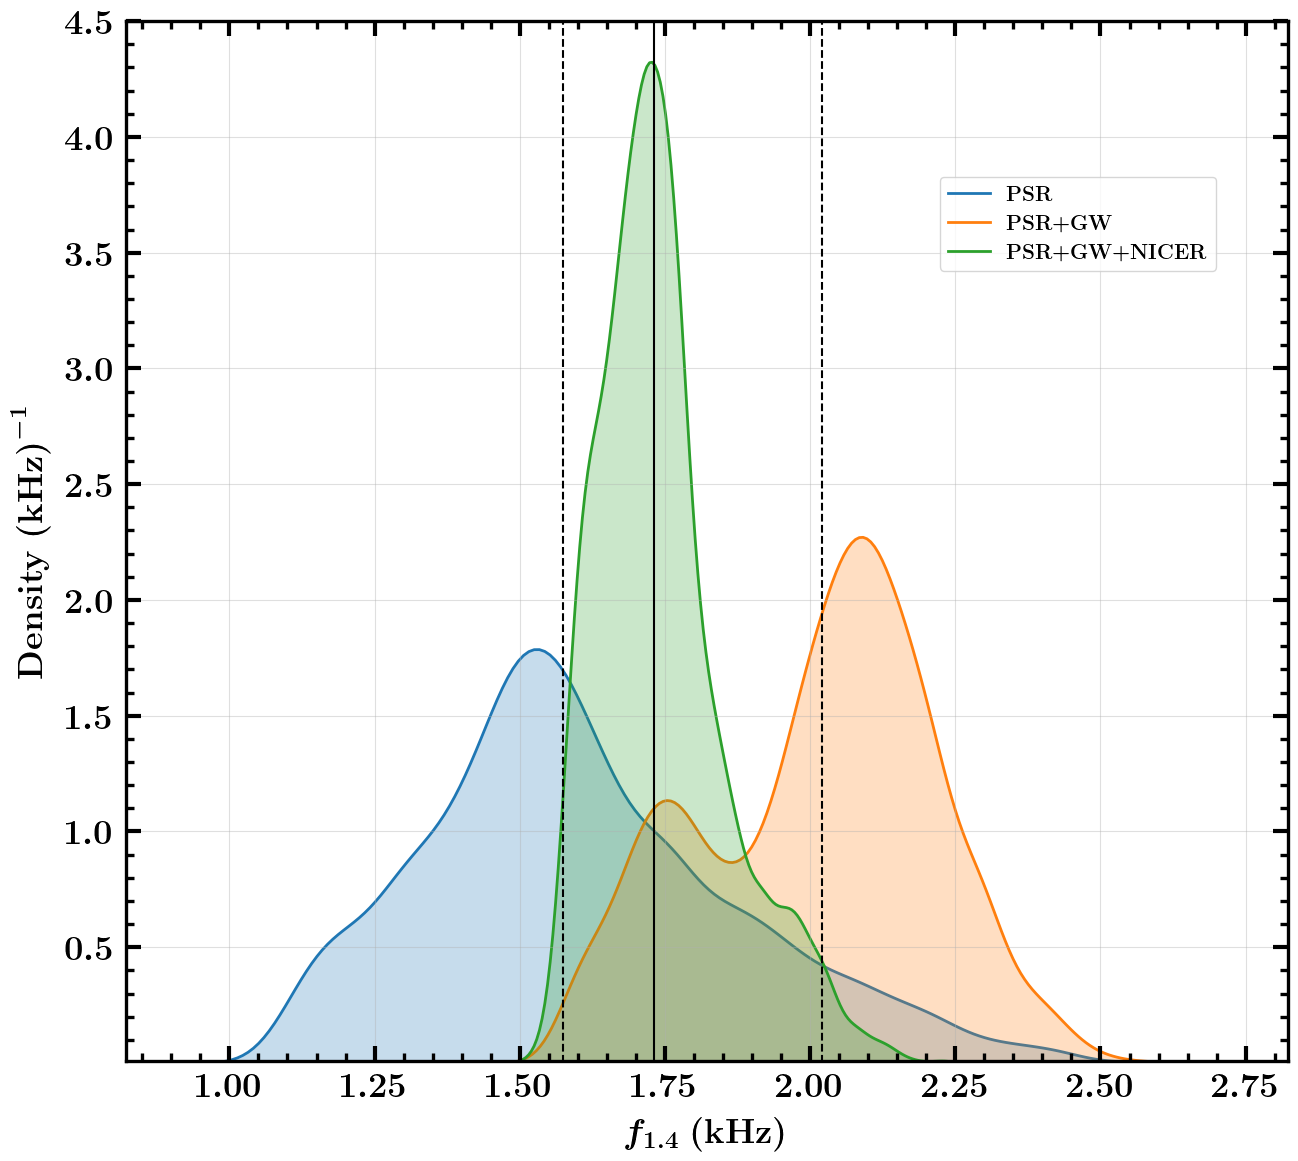

In [191]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

sns.kdeplot(PSR["f_1.4"],ax=ax,color="tab:blue",linewidth=2,fill=True) 
sns.kdeplot(GW["f_1.4"],ax=ax,color="tab:orange",linewidth=2,fill=True)
sns.kdeplot(NICER["f_1.4"],ax=ax,color="tab:green",linewidth=2,fill=True) 

f= np.linspace(0.5,3,200)

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_1.4"])(f),0.95,typ="median")

for i,f in enumerate(f_dat):
    if i==1 or i==2:
        ax.vlines(f,-1,10,colors="black",linestyle="--")
    else:
        ax.vlines(f,-1,10,colors="black")
        
ax.plot([],[],label=r"\bf{PSR}",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="tab:orange", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="tab:green", linewidth= 2)

ax.legend(loc=(0.7,0.76), prop={"size":15})
ax.set_ylim(0.01,4.5)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm Density \ \mathrm{(kHz)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$f_{1.4} \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/1D_f1.4.pdf", bbox_inches='tight')

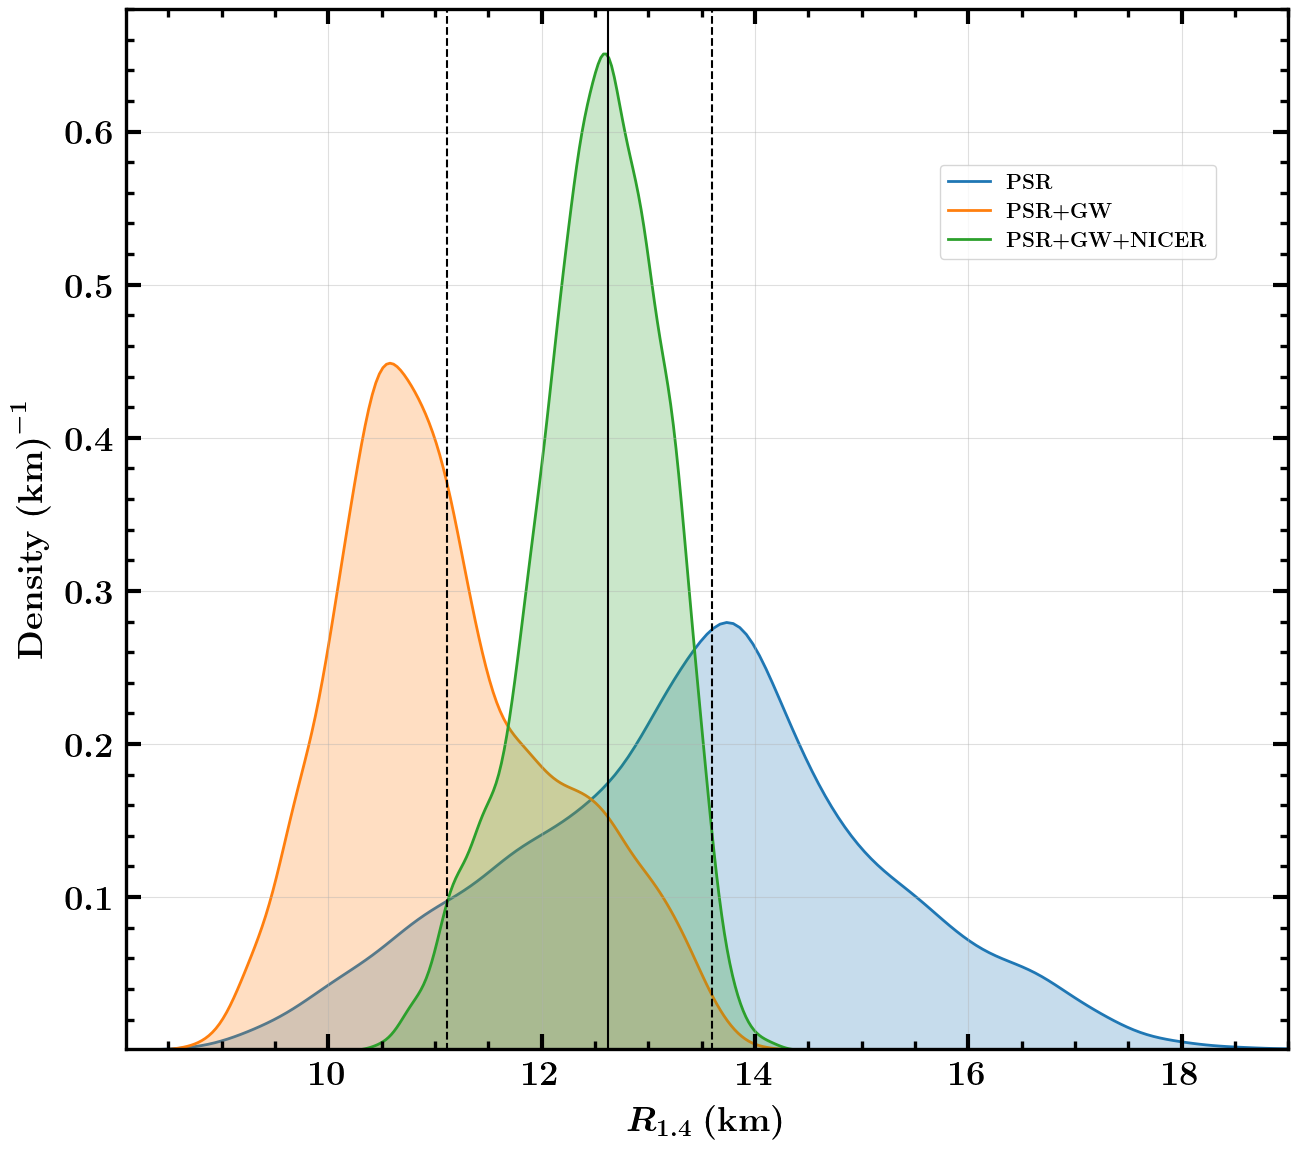

In [192]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

sns.kdeplot(PSR["R_1.4"],ax=ax,color="tab:blue",linewidth=2,fill=True) 
sns.kdeplot(GW["R_1.4"],ax=ax,color="tab:orange",linewidth=2,fill=True)
sns.kdeplot(NICER["R_1.4"],ax=ax,color="tab:green",linewidth=2,fill=True) 

R= np.linspace(7,20,200)

R_dat= CI_calc(R,st.gaussian_kde(NICER["R_1.4"])(R),0.95,typ="median")

for i,R in enumerate(R_dat):
    if i==1 or i==2:
        ax.vlines(R,-1,10,colors="black",linestyle="--")
    else:
        ax.vlines(R,-1,10,colors="black")
        
ax.plot([],[],label=r"\bf{PSR}",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="tab:orange", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="tab:green", linewidth= 2)

ax.legend(loc=(0.7,0.76), prop={"size":15})
ax.set_ylim(0.001,0.68)
ax.set_xlim(8.1,19)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm Density \ \mathrm{(km)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$R_{1.4} \ \mathrm{(km)}$", labelpad= 10)

plt.show()
fig.savefig("Plots/1D_R1.4.pdf", bbox_inches='tight')

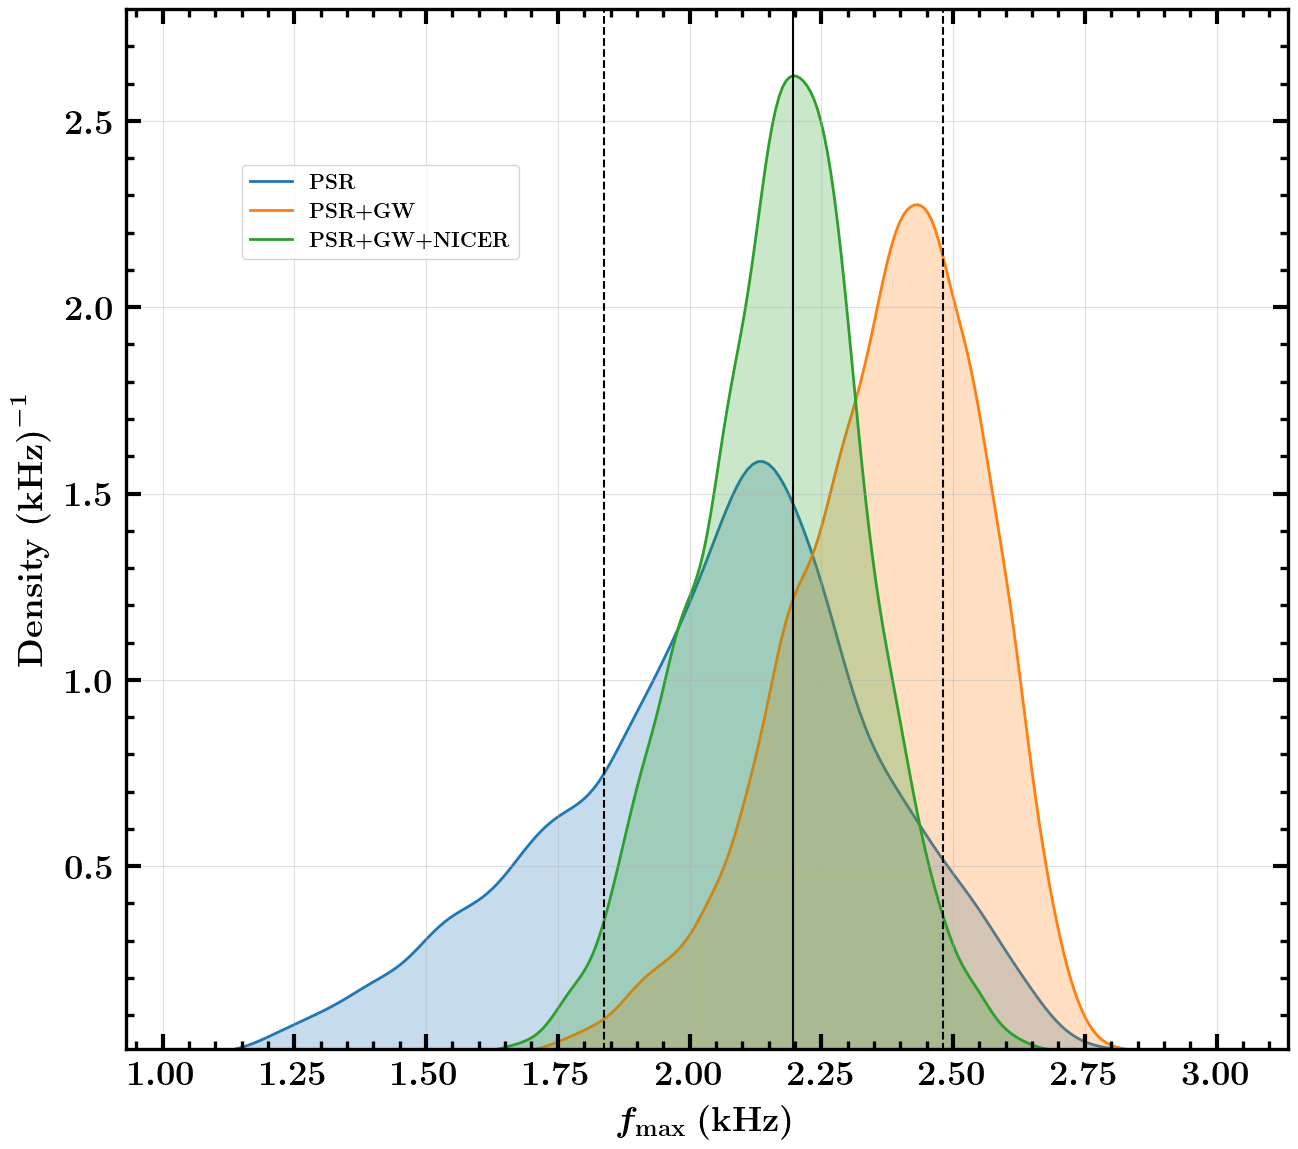

In [193]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

sns.kdeplot(PSR["f_max"],ax=ax,color="tab:blue",linewidth=2,fill=True) 
sns.kdeplot(GW["f_max"],ax=ax,color="tab:orange",linewidth=2,fill=True)
sns.kdeplot(NICER["f_max"],ax=ax,color="tab:green",linewidth=2,fill=True) 

f= np.linspace(0.5,3,200)

f_dat= CI_calc(f,st.gaussian_kde(NICER["f_max"])(f),0.95,typ="median")

for i,f in enumerate(f_dat):
    if i==1 or i==2:
        ax.vlines(f,-1,10,colors="black",linestyle="--")
    else:
        ax.vlines(f,-1,10,colors="black")
        
ax.plot([],[],label=r"\bf{PSR}",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="tab:orange", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="tab:green", linewidth= 2)

ax.legend(loc=(0.1,0.76), prop={"size":15})
ax.set_ylim(0.01,2.8)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm Density \ \mathrm{(kHz)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$f_{\max} \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()
fig.savefig("Plots/1D_fmax.pdf", bbox_inches='tight')

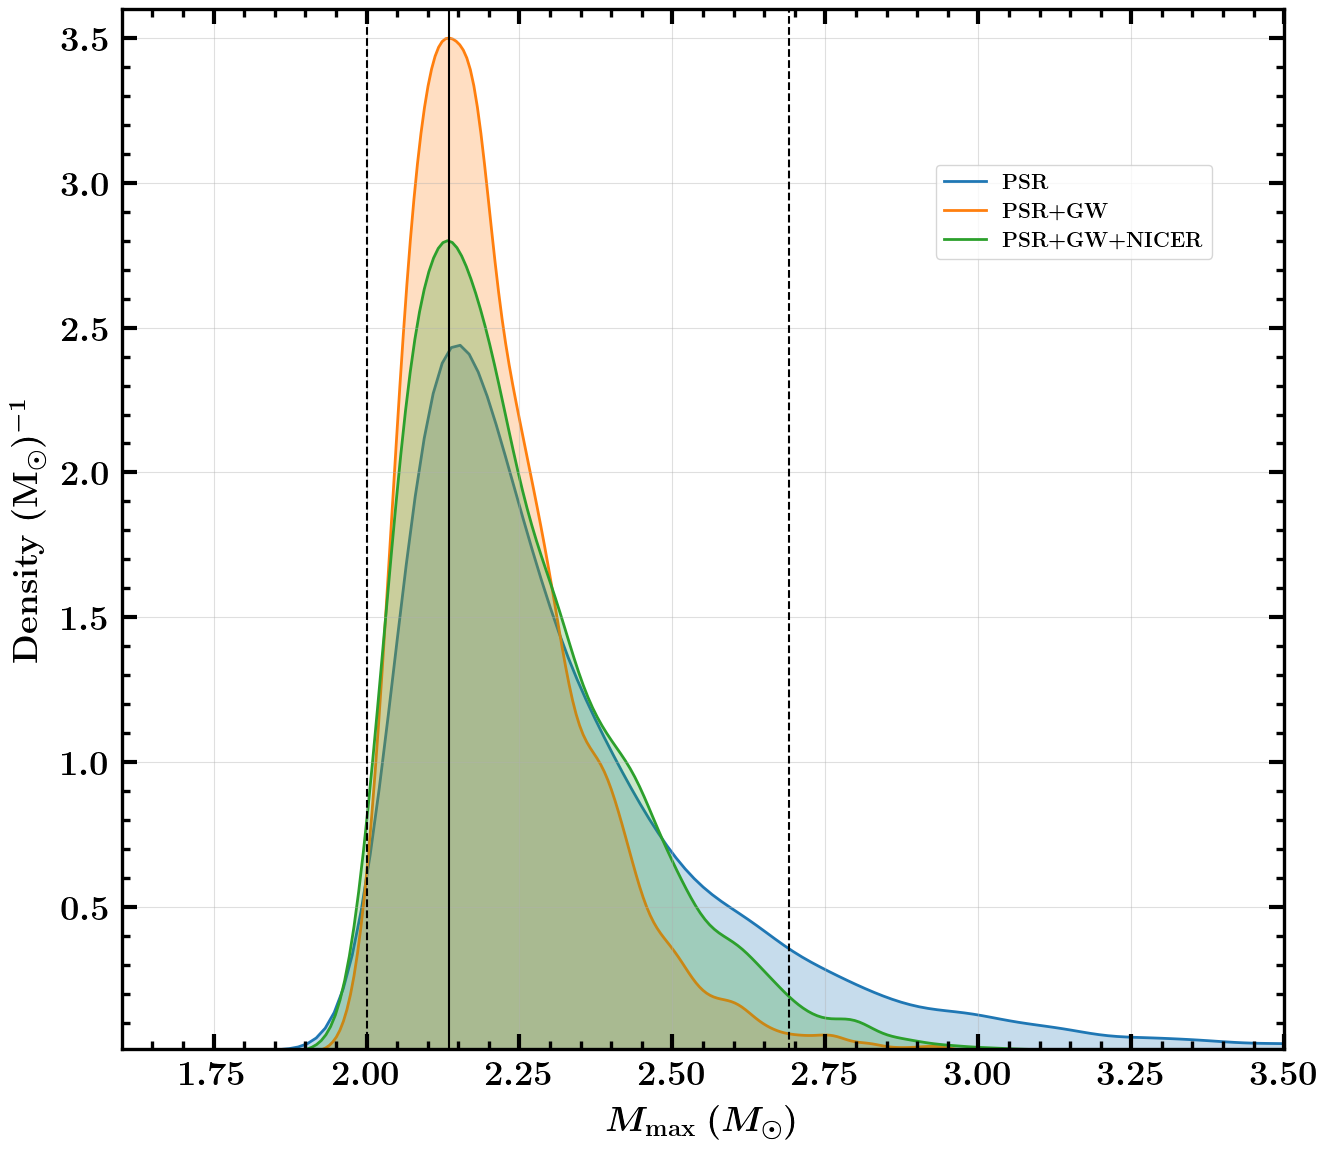

In [194]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

sns.kdeplot(PSR["M_max"],ax=ax,color="tab:blue",linewidth=2,fill=True) 
sns.kdeplot(GW["M_max"],ax=ax,color="tab:orange",linewidth=2,fill=True)
sns.kdeplot(NICER["M_max"],ax=ax,color="tab:green",linewidth=2,fill=True) 

M= np.linspace(0.8,4,200)

M_dat= CI_calc(M,st.gaussian_kde(NICER["M_max"])(M),0.95,typ="median")

for i,M in enumerate(M_dat):
    if i==1 or i==2:
        ax.vlines(M,-1,10,colors="black",linestyle="--")
    else:
        ax.vlines(M,-1,10,colors="black")
        
ax.plot([],[],label=r"\bf{PSR}",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="tab:orange", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="tab:green", linewidth= 2)

ax.legend(loc=(0.7,0.76), prop={"size":15})
ax.set_ylim(0.01,3.6)
ax.set_xlim(1.6,3.5)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm Density \ (M_\odot)^{-1}$", labelpad= 10)
ax.set_xlabel(r"$M_{\max} \ (M_\odot)$", labelpad= 10)

plt.show()

fig.savefig("Plots/1D_Mmax.pdf", bbox_inches='tight')

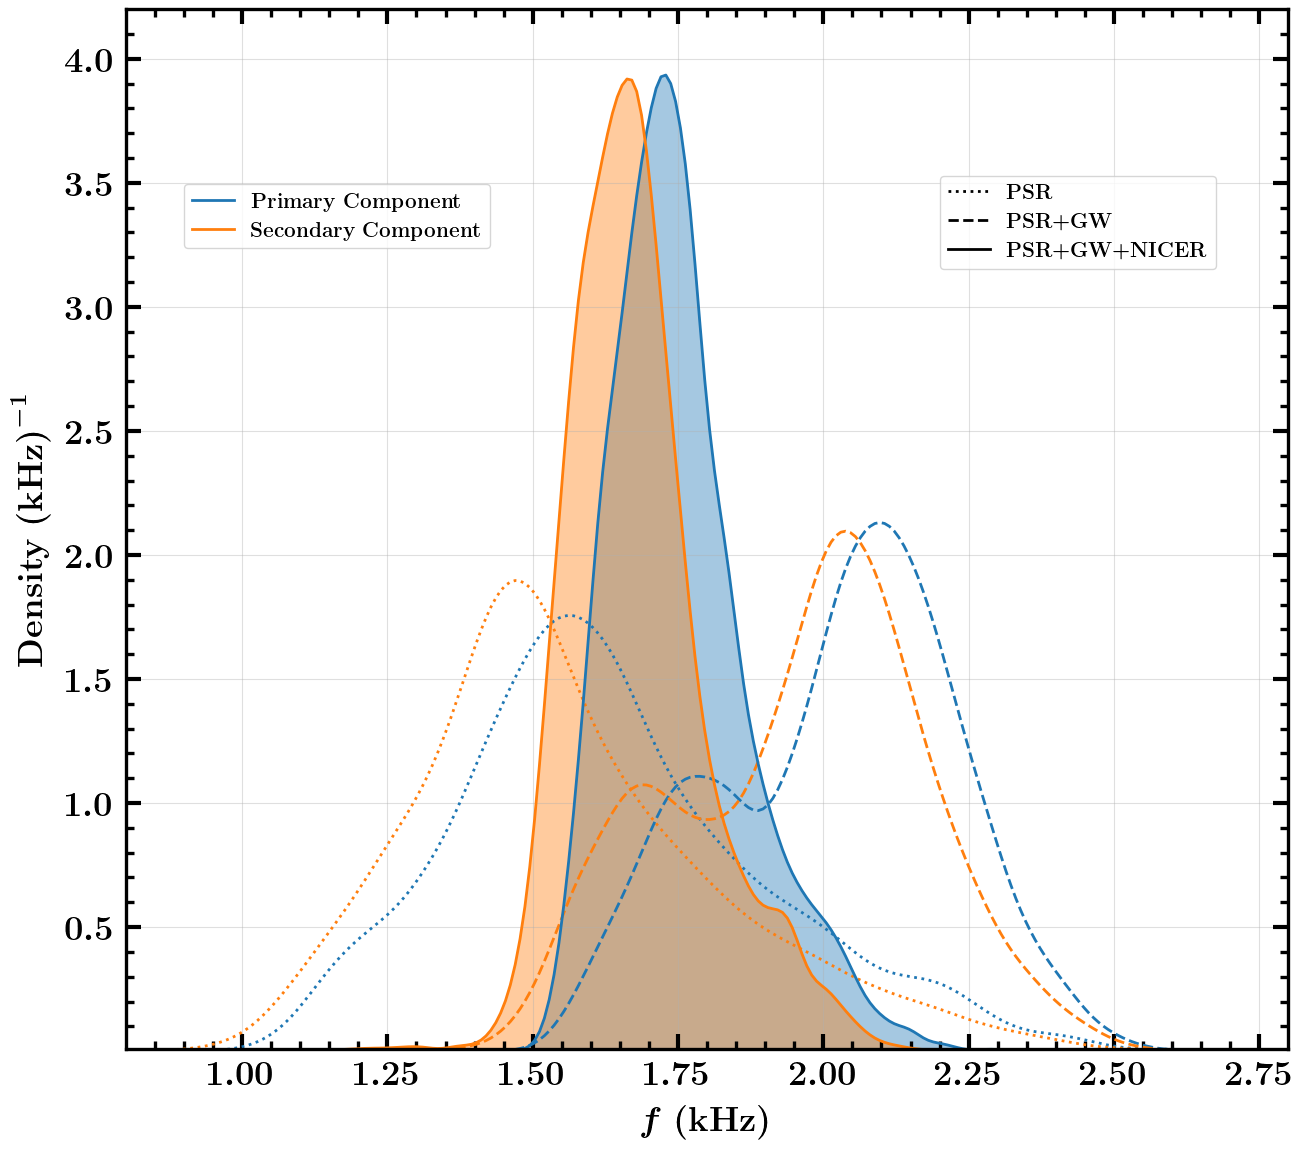

In [10]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

f= np.linspace(0.5,3,300)

ax.plot(f,st.gaussian_kde(PSR["GW170817"]["f1"])(f),color="tab:blue", linestyle=":", linewidth= 2)
ax.plot(f,st.gaussian_kde(PSR["GW170817"]["f2"])(f),color="tab:orange", linestyle=":", linewidth= 2)

ax.plot(f,st.gaussian_kde(GW["GW170817"]["f1"])(f),color="tab:blue", linestyle="--", linewidth= 2)
ax.plot(f,st.gaussian_kde(GW["GW170817"]["f2"])(f),color="tab:orange", linestyle="--", linewidth= 2)

ax.plot(f,st.gaussian_kde(NICER["GW170817"]["f1"])(f),color="tab:blue",linestyle="-", linewidth= 2)
ax.fill_between(f,st.gaussian_kde(NICER["GW170817"]["f1"])(f), alpha=0.4, color= "tab:blue")
ax.plot(f,st.gaussian_kde(NICER["GW170817"]["f2"])(f),color="tab:orange",linestyle="-", linewidth= 2)
ax.fill_between(f,st.gaussian_kde(NICER["GW170817"]["f2"])(f), alpha=0.4, color= "tab:orange")


# f1_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f1"])(f),0.95,typ="median")
# f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f2"])(f),0.95,typ="median")

# for i in range(3):
#     if i!=0:
#         ax.vlines(f1_dat[i],-1,10,colors="tab:blue",linestyle="--")
#         ax.vlines(f2_dat[i],-1,10,colors="tab:orange",linestyle="--")
        
ax.plot([],[],label=r"\bf{PSR}",color="black", linestyle=":", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="black", linestyle="--", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="black", linestyle="-", linewidth= 2)

leg1= ax.legend(loc=(0.7,0.75), prop={"size":15})

ax.plot([],[],label=r"\bf{Primary Component}",color="tab:blue", linestyle="-", linewidth= 2)
ax.plot([],[],label=r"\bf{Secondary Component}",color="tab:orange", linestyle="-", linewidth= 2)

lines= ax.get_lines()
leg2= ax.legend([lines[i] for i in [-2,-1]],[lines[i].get_label() for i in [-2,-1]],loc=(0.05,0.77), prop={"size":15})

ax.add_artist(leg1)


ax.set_ylim(0.01,4.2)
ax.set_xlim(0.8,2.8)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm Density \ \mathrm{(kHz)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$f \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

# fig.savefig("Plots/1D_GW17_fmode.pdf", bbox_inches='tight')

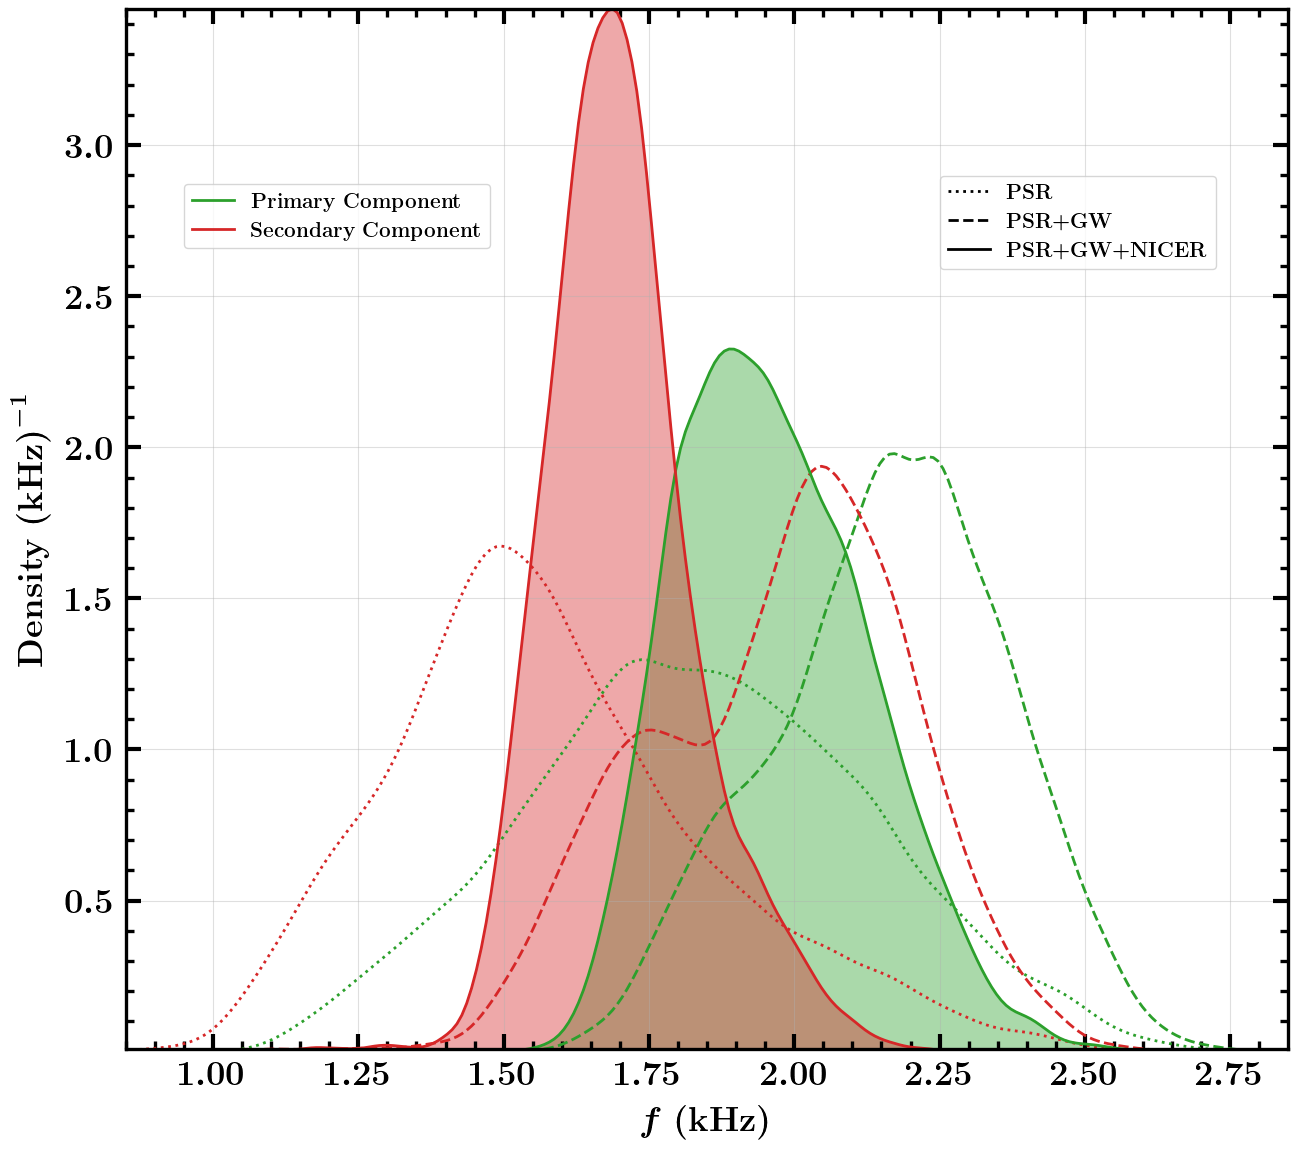

In [9]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

f= np.linspace(0.5,3,300)

ax.plot(f,st.gaussian_kde(PSR["GW190425"]["f1"])(f),color="tab:green", linestyle=":", linewidth= 2)
ax.plot(f,st.gaussian_kde(PSR["GW190425"]["f2"])(f),color="tab:red", linestyle=":", linewidth= 2)

ax.plot(f,st.gaussian_kde(GW["GW190425"]["f1"])(f),color="tab:green", linestyle="--", linewidth= 2)
ax.plot(f,st.gaussian_kde(GW["GW190425"]["f2"])(f),color="tab:red", linestyle="--", linewidth= 2)

ax.plot(f,st.gaussian_kde(NICER["GW190425"]["f1"])(f),color="tab:green",linestyle="-", linewidth= 2)
ax.fill_between(f,st.gaussian_kde(NICER["GW190425"]["f1"])(f), alpha=0.4, color= "tab:green")
ax.plot(f,st.gaussian_kde(NICER["GW190425"]["f2"])(f),color="tab:red",linestyle="-", linewidth= 2)
ax.fill_between(f,st.gaussian_kde(NICER["GW190425"]["f2"])(f), alpha=0.4, color= "tab:red")


# f1_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f1"])(f),0.95,typ="median")
# f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW170817"]["f2"])(f),0.95,typ="median")

# for i in range(3):
#     if i!=0:
#         ax.vlines(f1_dat[i],-1,10,colors="tab:blue",linestyle="--")
#         ax.vlines(f2_dat[i],-1,10,colors="tab:orange",linestyle="--")
        
ax.plot([],[],label=r"\bf{PSR}",color="black", linestyle=":", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW}",color="black", linestyle="--", linewidth= 2)
ax.plot([],[],label=r"\bf{PSR+GW+NICER}",color="black", linestyle="-", linewidth= 2)

leg1= ax.legend(loc=(0.7,0.75), prop={"size":15})

ax.plot([],[],label=r"\bf{Primary Component}",color="tab:green", linestyle="-", linewidth= 2)
ax.plot([],[],label=r"\bf{Secondary Component}",color="tab:red", linestyle="-", linewidth= 2)

lines= ax.get_lines()
leg2= ax.legend([lines[i] for i in [-2,-1]],[lines[i].get_label() for i in [-2,-1]],loc=(0.05,0.77), prop={"size":15})

ax.add_artist(leg1)

ax.set_ylim(0.01,3.45)
ax.set_xlim(0.85,2.85)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm Density \ \mathrm{(kHz)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$f \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

# fig.savefig("Plots/1D_GW19_fmode.pdf", bbox_inches='tight')

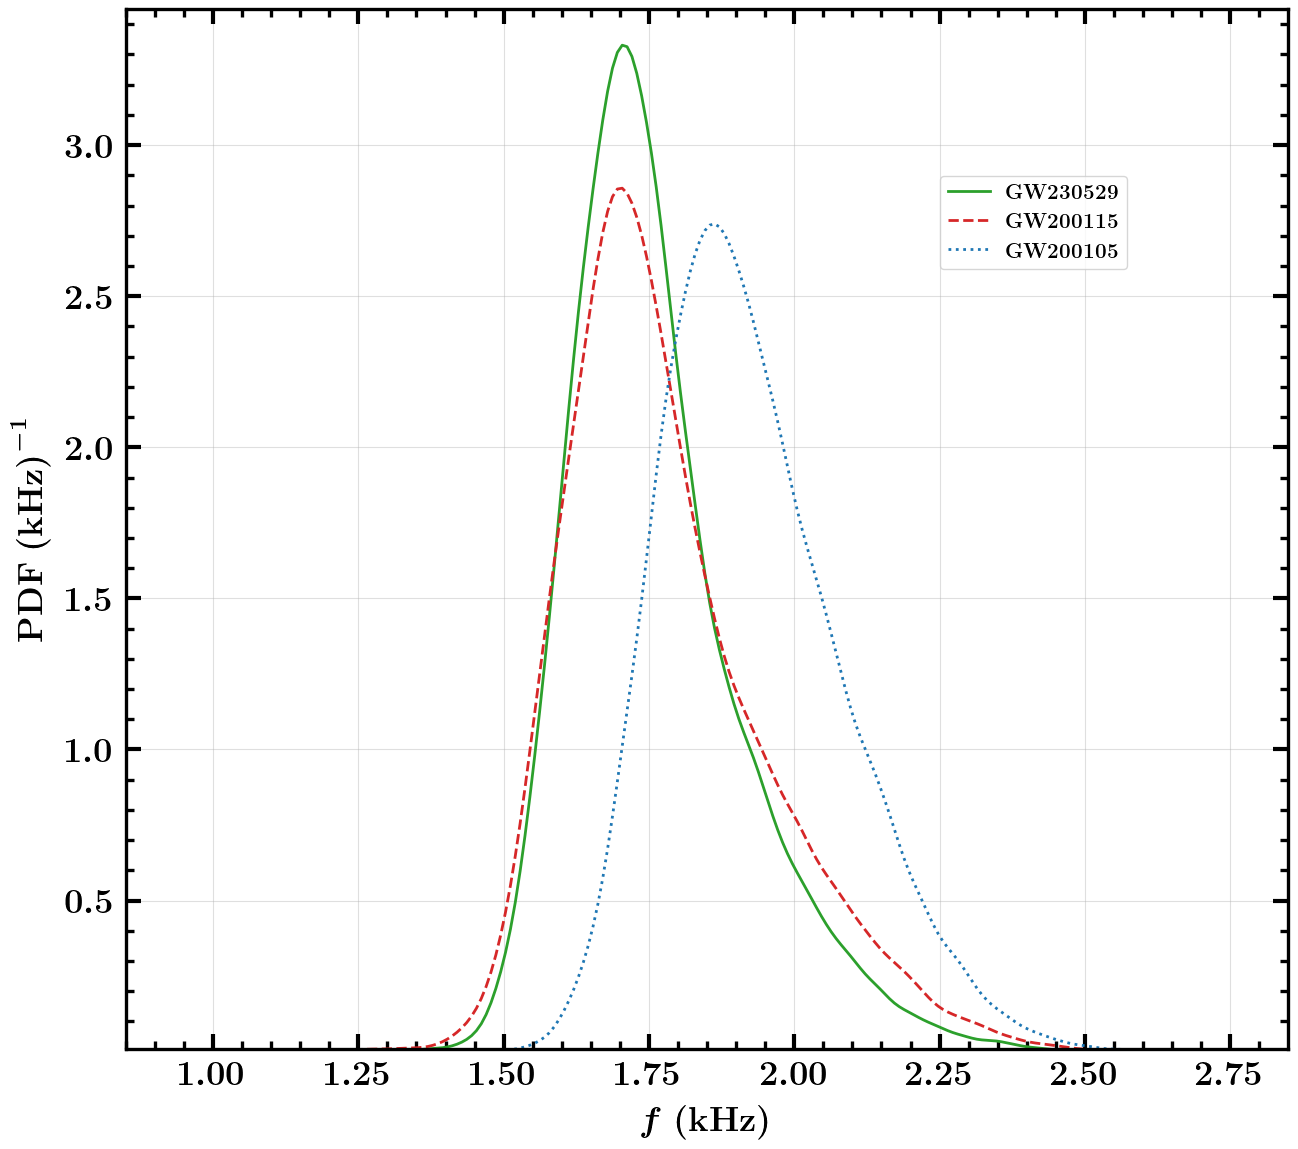

In [174]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

f= np.linspace(0.5,3,300)

ax.plot(f,st.gaussian_kde(NICER["GW230529"]["f2"])(f),color="tab:green",linestyle="-", linewidth= 2, label=r"\bf{GW230529}")
ax.plot(f,st.gaussian_kde(NICER["GW200115"]["f2"])(f),color="tab:red", linestyle="--", linewidth= 2, label=r"\bf{GW200115}")
ax.plot(f,st.gaussian_kde(NICER["GW200105"]["f2"])(f),color="tab:blue", linestyle=":", linewidth= 2, label=r"\bf{GW200105}")

ax.legend(loc=(0.7,0.75), prop={"size":15})

ax.set_ylim(0.01,3.45)
ax.set_xlim(0.85,2.85)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm PDF \ \mathrm{(kHz)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$f \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

# fig.savefig("Plots/1D_GW19_fmode.pdf", bbox_inches='tight')

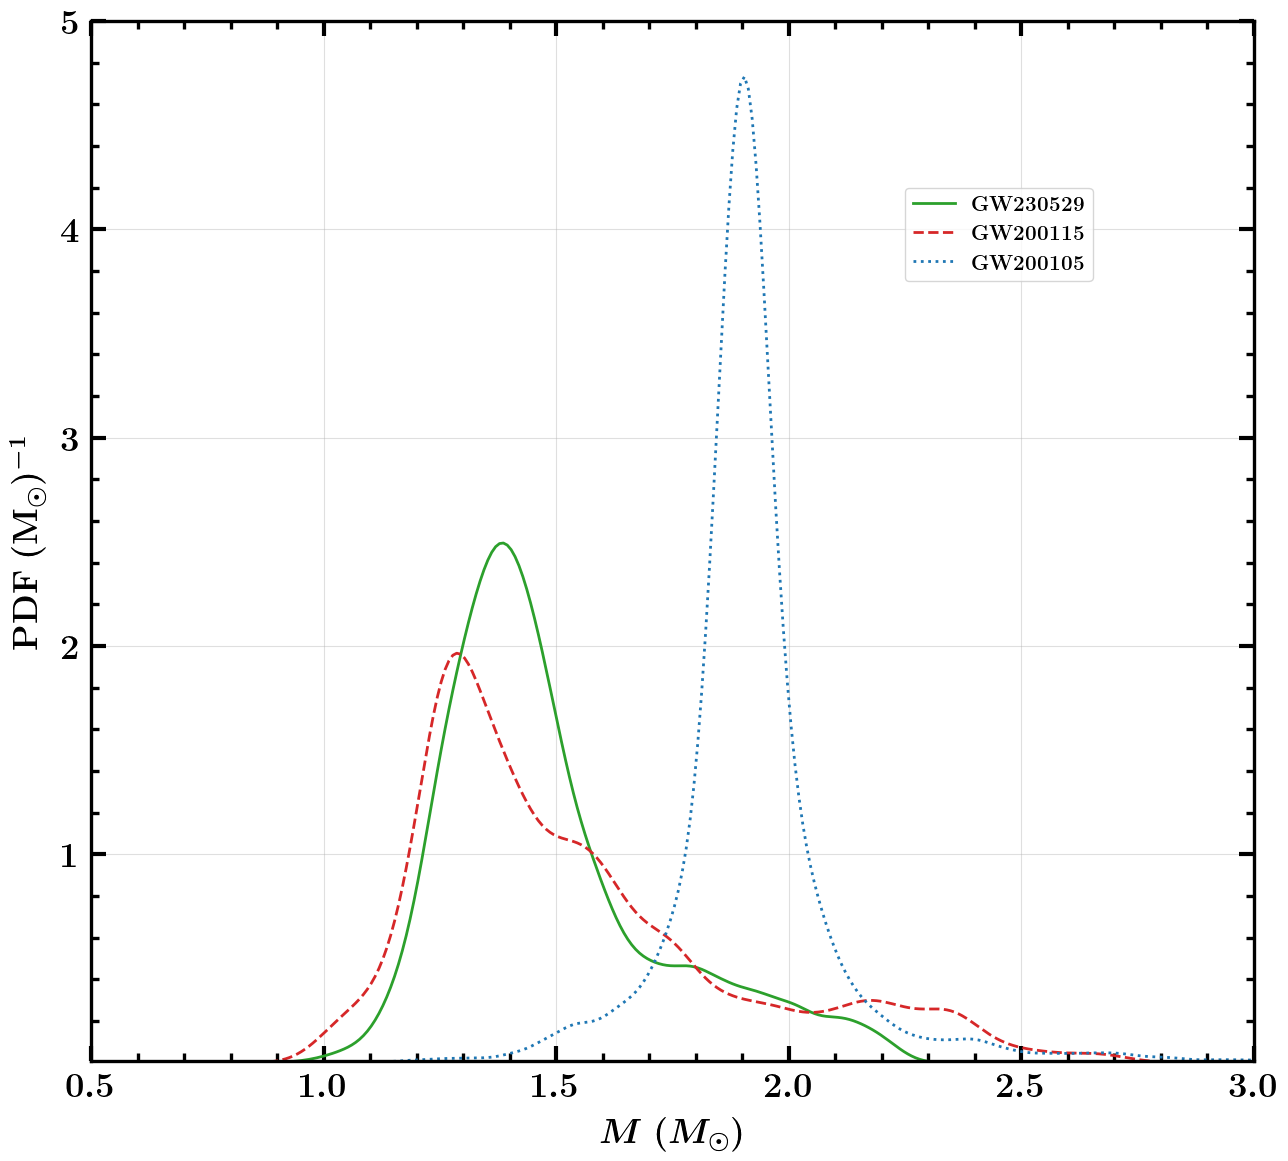

In [175]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

M= np.linspace(0.5,3,300)

ax.plot(f,st.gaussian_kde(NICER["GW230529"]["M2"])(M),color="tab:green",linestyle="-", linewidth= 2, label=r"\bf{GW230529}")
ax.plot(f,st.gaussian_kde(NICER["GW200115"]["M2"])(M),color="tab:red", linestyle="--", linewidth= 2, label=r"\bf{GW200115}")
ax.plot(f,st.gaussian_kde(NICER["GW200105"]["M2"])(M),color="tab:blue", linestyle=":", linewidth= 2, label=r"\bf{GW200105}")

ax.legend(loc=(0.7,0.75), prop={"size":15})

ax.set_ylim(0.01,5)
ax.set_xlim(0.5,3)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm PDF \ (M_\odot)^{-1}$", labelpad= 10)
ax.set_xlabel(r"$M \ (M_\odot)$", labelpad= 10)

plt.show()

# fig.savefig("Plots/1D_GW19_fmode.pdf", bbox_inches='tight')

In [177]:
f2_dat= CI_calc(f,st.gaussian_kde(PSR["GW200105"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(PSR["GW200105"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2_dat= CI_calc(f,st.gaussian_kde(GW["GW200105"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(GW["GW200105"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW200105"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(NICER["GW200105"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2=$1.83^{+0.54}_{-0.48}$
M2=$1.91^{+0.34}_{-0.24}$
f2=$2.18^{+0.32}_{-0.37}$
M2=$1.91^{+0.34}_{-0.24}$
f2=$1.93^{+0.29}_{-0.23}$
M2=$1.91^{+0.34}_{-0.24}$


In [178]:
f2_dat= CI_calc(f,st.gaussian_kde(PSR["GW200115"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(PSR["GW200115"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2_dat= CI_calc(f,st.gaussian_kde(GW["GW200115"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(GW["GW200115"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW200115"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(NICER["GW200115"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2=$1.66^{+0.56}_{-0.45}$
M2=$1.54^{+0.75}_{-0.40}$
f2=$2.04^{+0.36}_{-0.40}$
M2=$1.54^{+0.75}_{-0.40}$
f2=$1.78^{+0.34}_{-0.23}$
M2=$1.54^{+0.75}_{-0.40}$


In [179]:
f2_dat= CI_calc(f,st.gaussian_kde(PSR["GW230529"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(PSR["GW230529"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2_dat= CI_calc(f,st.gaussian_kde(GW["GW230529"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(GW["GW230529"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2_dat= CI_calc(f,st.gaussian_kde(NICER["GW230529"]["f2"])(f),0.9,typ="mean")
M2_dat= CI_calc(M,st.gaussian_kde(NICER["GW230529"]["M2"])(M),0.9,typ="mean")

print("f2=" + error_str(f2_dat))
print("M2=" + error_str(M2_dat))

f2=$1.64^{+0.55}_{-0.44}$
M2=$1.48^{+0.51}_{-0.29}$
f2=$2.03^{+0.35}_{-0.39}$
M2=$1.48^{+0.51}_{-0.29}$
f2=$1.76^{+0.29}_{-0.20}$
M2=$1.48^{+0.51}_{-0.29}$
